# Connected and Autonomous Driving - Visual Perception Module
Lab credits: [François Robinet](mailto:francois.robinet@uni.lu)

----

This assignement is separated in 3 parts related to visual percepetion:
- In the first, you will learn about creating an image classification model from nothing.
- In the second, you will how to use and fine-tune a detection model.
- In the third, you will learn how to use this model in a simulation environment.

In this assignment, we will learn how to tackle the complex problem of classifying traffic signs. These signs come in many shapes, colors and forms, and it is hard even for us to express how exactly we identify traffic signs. This makes learning from actual data an ideal fit for this problem!

The following concepts will be covered in this Lab:

1. Loading data in a format suitable for learning algorithms
1. Implementation of a Softmax Classifier in plain PyTorch
1. Performance assessment in machine learning
1. GPU Implementation of complex classification models using PyTorch
1. Regularization in the context of neural networks (data augmentation, dropout, early stopping)
1. Fine-tuning a pre-trained detection model to fit an application

In this lab, we will leverage the GPU capabilities of Google Colab. To enable a GPU for this notebook, go to "Execution > Change Execution Type" and add GPU capabilities. Executing the next cell should succeed and show one available GPU.


In [ ]:
! nvidia-smi

Mon Dec 16 18:21:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Loading Traffic Sign Data

You will find the traffic sign dataset used for this assignment `traffic_signs.zip` in the git page of this project.

download the corresponding zip file and upload it to the repository of this google collab, then run the following cell.

In [ ]:
# BECAUSE WE WERE WORKING ON COLAB
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [ ]:
from pathlib import Path

FILENAME="traffic_signs.zip"
traffic_signs_dir = Path("/content") / "datasets/traffic_signs_data"
traffic_signs_dir.mkdir(parents=True, exist_ok=True)
print(f"Extracting the traffic sign dataset")
! unzip "traffic_signs.zip" -d $traffic_signs_dir

Extracting the traffic sign dataset
Archive:  traffic_signs.zip
  inflating: /content/datasets/traffic_signs_data/signnames.csv  
  inflating: /content/datasets/traffic_signs_data/test.p  
  inflating: /content/datasets/traffic_signs_data/train.p  
  inflating: /content/datasets/traffic_signs_data/valid.p  


The traffic sign data is split into train / validation / test datasets.
Each of this dataset has can be loaded directly using `numpy.load`.

The data contains the following data for the traffic signs:

- `features`: the traffic sign 32x32 3-channel RGB images
- `labels`: a single label for each sample, represented as a number in [0,42]. These numbers relate to each of the 43 traffic signs names that are read from  `signnames.csv`.

Let's load the 34799 samples of the training set and display a 16 random images with their labels.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

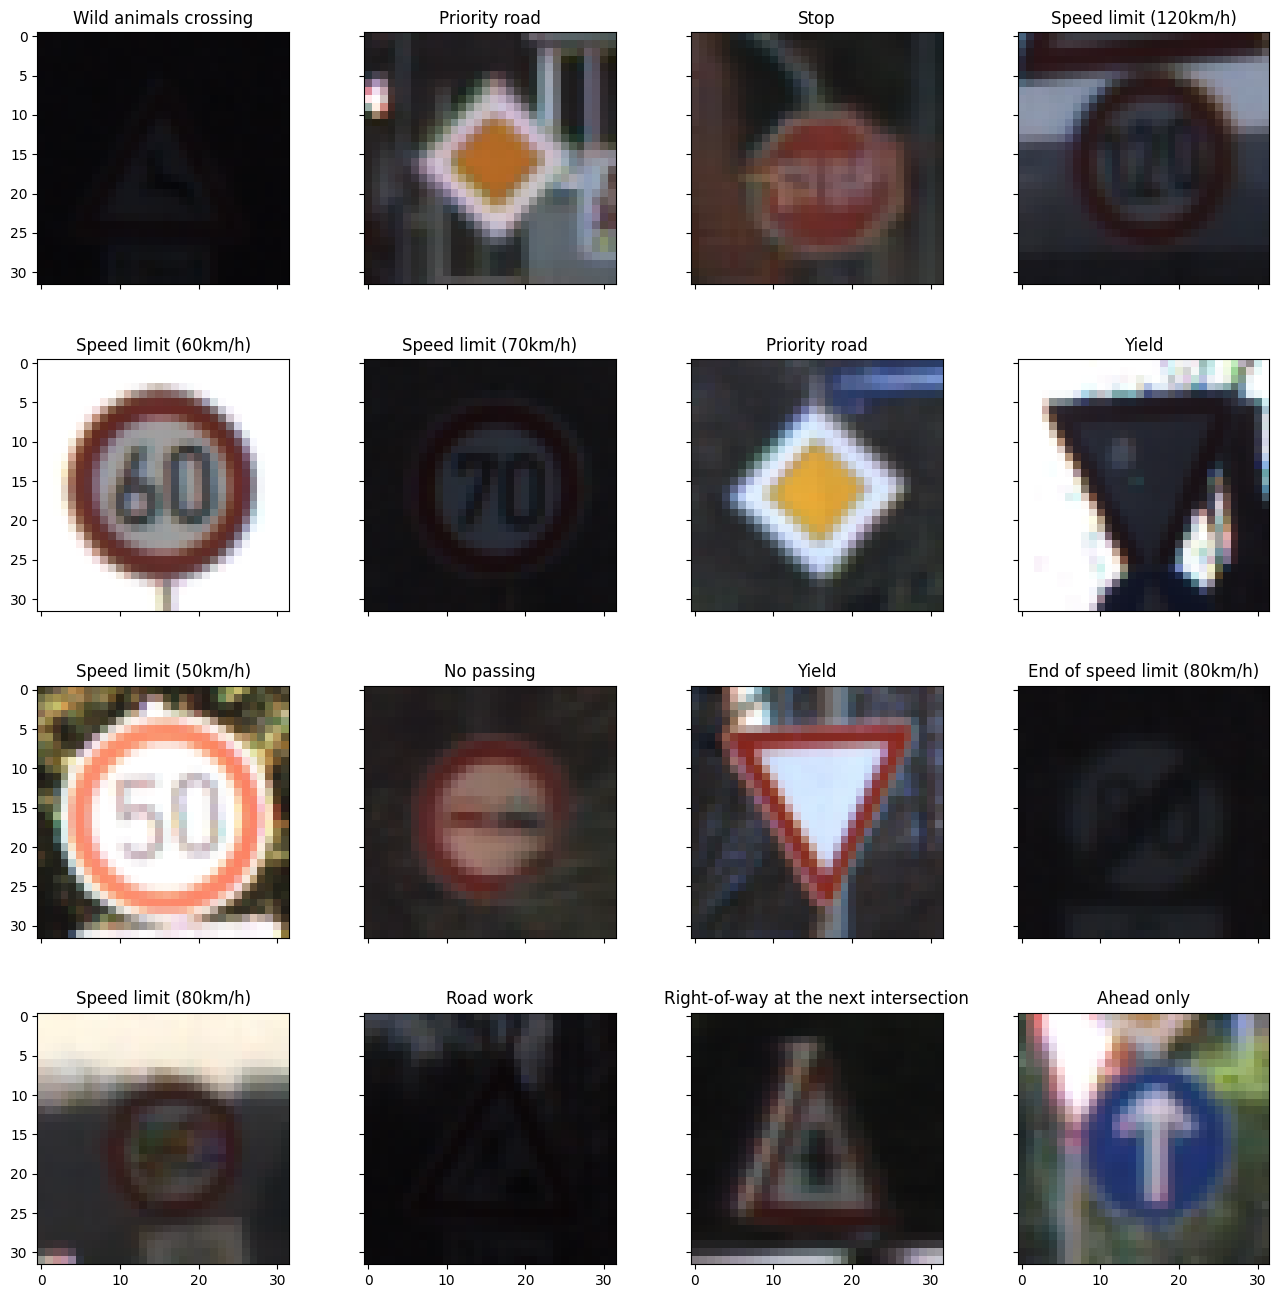

In [ ]:
def load_data(path):
  data = np.load(path, allow_pickle=True)
  images, labels = data["features"], data["labels"]
  # Pixels are stored as unsigned integers in [0,255]
  # Because our numerical operations treat these as floating point numbers,
  # it's best to convert these numbers to float and map them to [0,1]
  images = images.astype(np.float32) / 255.0
  labels = labels.astype(np.int64)
  return images, labels

def show_image_grid(images, titles):
  fig = plt.figure(figsize=(16,16))
  ncols = 4
  nrows = int(np.ceil(images.shape[0] // ncols))
  grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.75)
  for ax, img, title in zip(grid, images, titles):
    ax.imshow(img)
    ax.set_title(title)

# Read data
sign_names = pd.read_csv(traffic_signs_dir / "signnames.csv").SignName.values
training_images, training_labels = load_data(traffic_signs_dir / "train.p")
training_size = training_labels.shape[0]

# Display 16 random images with their labels
random_indices = np.random.choice(np.arange(training_size), size=16, replace=False)
show_image_grid(training_images[random_indices], sign_names[training_labels[random_indices]])


## Classification with a Single Layer: Logistic/Softmax Regression

### Model

Our first approach will be to implement a simple linear classifier using numpy only. This means that our output will be predicted as

$$\hat{y} = \sigma(Wx+b)$$

where

- $x$ is a vector image pixel values. Shape is $(3*32*32,) = (3072,)$.
- $\hat{y}$ is a $(43,)$ shaped vector containing a probability value for each class.
- $W$ is a (43,3072) matrix of weights to be learned. The weights will be initialized to random numbers in $[0,1]$. More advanced strategies exist and will be covered in the next parts.
- $b$ is a vector of weights called the biases, that will also be learned. Its shape is $(43,)$
- $\sigma$ is the softmax activation function which will project values in $Wx$ into $[0,1]$ and make them sum to one: $\sigma(x)_i = \frac{e^{x_i}}{\sum_je^{x_j}}$.



### From Theory to Practice: Implementing the model

Let's now implement our softmax classifier in PyTorch. We can easily do so by creating a new class deriving from `torch.nn.Module` and implementing the computation in its `forward` method. You'll learn more about why this is called `forward` next week.

If you want to show the documentation relative to a function like `torch.nn.Parameter`, just execute the following code in a cell and documentation will pop-up.

```
torch.nn.Parameter?
```


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
class SoftmaxClassifier(nn.Module):
  def __init__(self):
    super().__init__() # Mandatory: PyTorch does some setting up in there!
    # Create our weight Tensor W. It will be of type float and have shape (1,43,3*32*32)
    # The extra first dimension is there because nn.Modules are meant to process
    # batches of inputs, and the inputs after reshaping will have shape (B, 3072, 1),
    # where B is the batch size. Adding an extra dimension is needed for numpy
    # to broadcast the first dimension of our weights to B.
    W_shape = (1, 43, 3072) # TODO
    bias_shape = (1, 43) # TODO
    # Since we want to learn these weights, we will create them as "parameters" (another name for weights)
    # Initialize parameters with random numbers in [0,1] (biases can be initialized to zero)
    # Better init stategies exist and will be covered later on
    self.W = nn.Parameter(torch.Tensor(*W_shape))
    nn.init.uniform_(self.W, 0.0, 1.0)
    self.bias = nn.Parameter(torch.zeros(bias_shape))

  def forward(self, x):
    # The formula treats x as a vector, but we're receiving a batch of images
    # with shape (B,32,32,3), which we reshape to (B,32*32*3,1).
    x = x.contiguous().view(x.shape[0], -1, 1)
    # TODO: Compute our prediction y_hat following the formula in the description above
    # Hint: the softmax function is available as torch.nn.functional.softmax (here F.softmax)
    # Keep in mind that you want to compute the softmax separately on each image,
    # so no softmax on dim 0!
    y_hat = F.softmax((self.W @ x).squeeze(dim=2) + self.bias, dim=1) # TODO
    return torch.squeeze(y_hat) # Squeeze removes any extra dimension with value 1, so we're back to (B,43) shape

# Create our classifier
softmax_classifier = SoftmaxClassifier()

### Our very first prediction

We have a randomly intialized model, let's use it to make a prediction on a random batch of images!

Remember that we are predicting 43 numbers for each image, which according to our model can be interpreted as the probability of each class to be the "right one". To get an actual prediction, we can simply grab the class with maximal probability.

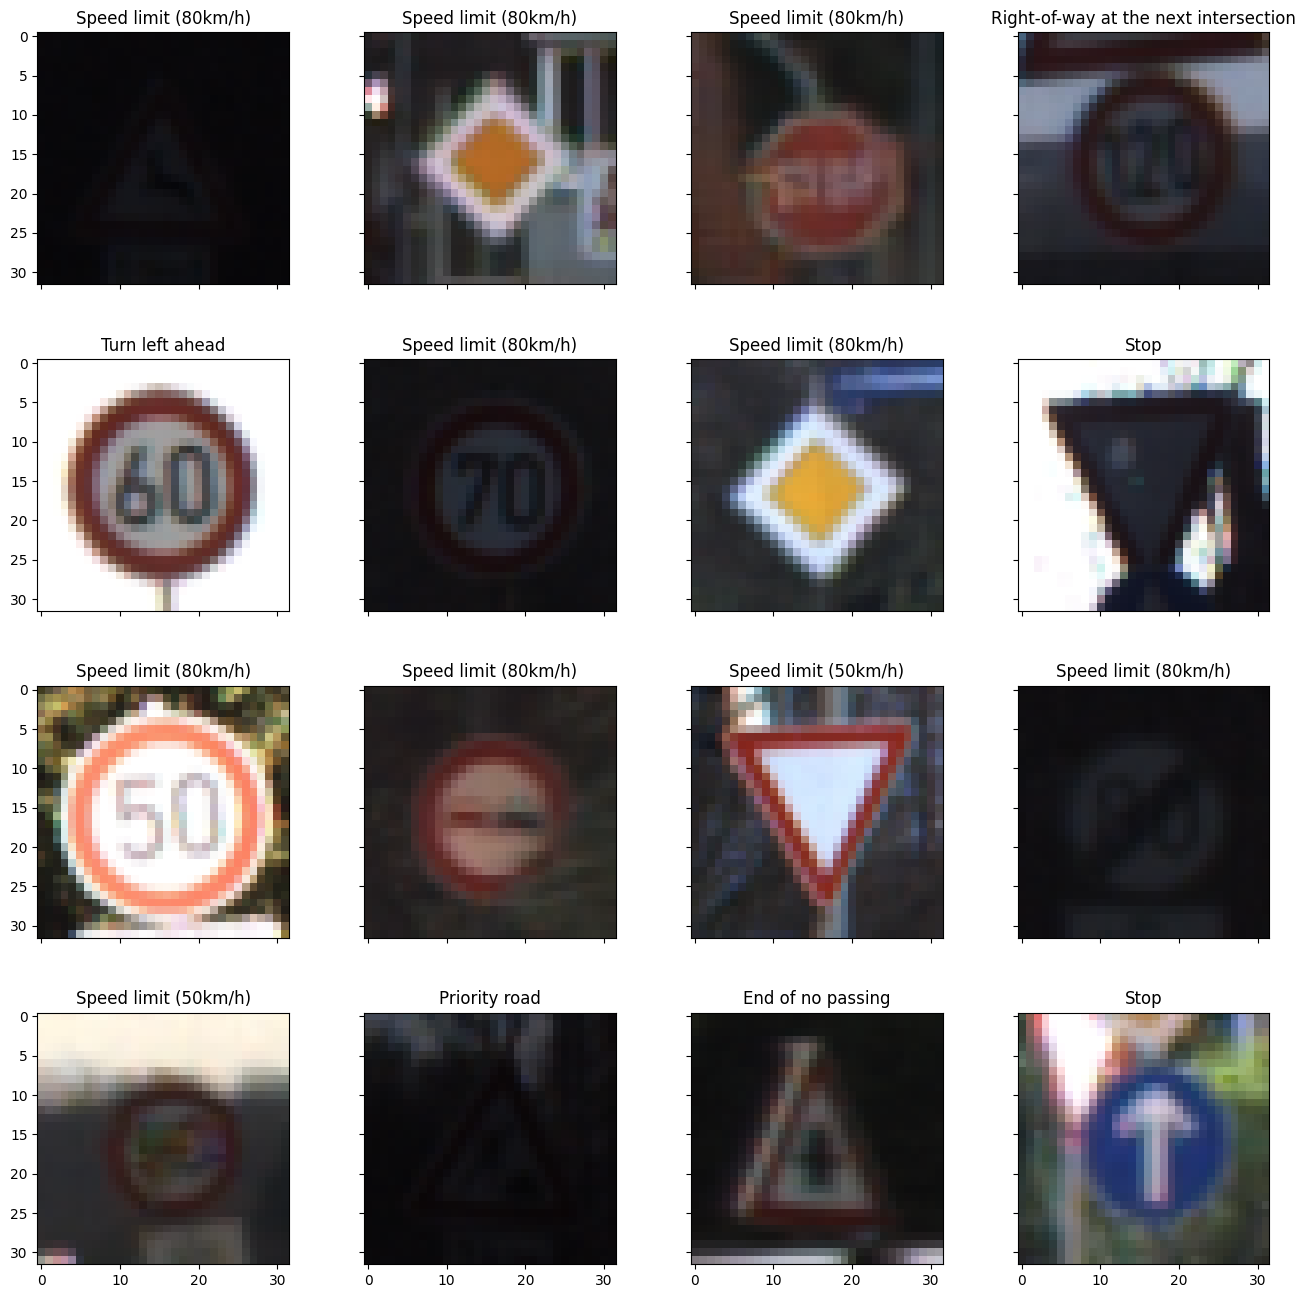

In [ ]:
# We will reuse the random batch of 16 images we showed when loading the data
input_images = torch.from_numpy(training_images[random_indices]) # This has shape (16,32,32,3)
input_images = input_images.permute(0, 3, 1, 2)
with torch.no_grad(): # Don't worry about no_grad for now, it just means we're not trying to optimize anything
  # TODO: Compute class probabilities by feeding the random_batch to your model (just a function call like "model(x)")
  y_pred = softmax_classifier(input_images) # Class probabilities
  assert y_pred.shape == (input_images.shape[0],sign_names.shape[0]), f"Predicted shape should be {(input_images.shape[0],sign_names.shape[0])} and is {y_pred.shape}."

# TODO: Find the most probable label for each image according to our model
# Hint: torch.argmax should help you there, just keep in mind that you want the max *per-image* (so don't argmax on dimension 0)
predicted_labels = torch.argmax(y_pred, dim=1) # Most probable label for each image
assert predicted_labels.shape == (input_images.shape[0],), f"Predicted labels shape should be {(input_images.shape[0],)} and is {(input_images.shape[0],)}"
predicted_sign_names = sign_names[predicted_labels]

# Show the image and their predicted class
show_image_grid(input_images.permute(0, 2, 3, 1).numpy(), predicted_sign_names)

### Training our Model

Our first prediction is rather... disappointing. It's not surprising though: we've learned a lot, but our model hasn't and it's predicting at random, often choosing the same class for most inputs! Let's see if we can fix this!

#### Loss Function

We first transform each ground truth label into a one-hot encoded vector

$$
\begin{equation}
  y_i=\begin{cases}
    1 & \text{if sample has class } i\\
    0 & \text{otherwise}.
  \end{cases}
\end{equation}
$$

We want to make $\hat{y}$ close to the ground truth $y$, which can be done in several ways. For multinomial classification, it is very common to use the "Negative Log-Likelihood Loss" we covered in class. In PyTorch, this loss function $L(y,\hat{y})$ is implemented in `torch.nn.NLLLoss`.


#### Stochastic Gradient Descent

Stochastic Gradient Descent iteratively updates the weights in order to minimize $L(\hat{y},y)$. Remember that $L$ depends on the weights because each prediction $\hat{y} = \sigma(Wx+b)$ depends on them.

We seek to compute the optimal weights $W^*$ such that

$$W^* = \underset{W,b}{\mathrm{argmin}}\ L(\sigma(Wx+b),y)$$

Gradient-based optimization iteratively improves on weight estimates $(W_k, W_{k+1}, ...)$ and $(b_k, b_{k+1}, ...)$ by making steps in the direction opposite to the gradient/jacobian directions

\begin{equation}
\begin{cases}
    W_{k+1} &= W_k - \alpha \nabla_W L\\
    b_{k+1} &= b_k - \alpha \nabla_b L
\end{cases}
\end{equation}

Where $\alpha$ defines a "step size", usually refered to as "learning rate" in machine learning. There are also more fancy ways to update parameters at each iteration, and we will discuss these in later classes.

Computing $\nabla_W L$ and $\nabla_b L$ is not trivial and will be covered in later classes.
One of the primary reasons for using Deep Learning frameworks like PyTorch or Tensorflow is that they will compute these for us!


In [ ]:
from tqdm.notebook import tqdm # We'll use this for nice progress bars

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Training Loss')

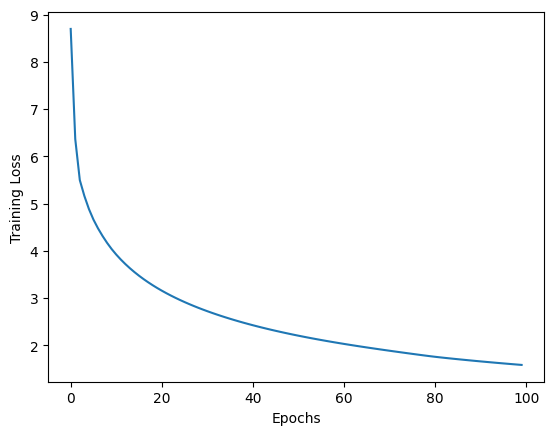

In [ ]:
# Training Loop:
#   - separate the training data into batches of 64 samples
#   - each epoch goes over all the batches in the dataset, and we can repeat the process for many epochs
#   - we feed each batch to our model, compute a loss, compute its gradient, and perform an SGD update
batch_size = 256
num_epochs = 100
learning_rate = 5e-3
batches_per_epoch = int(np.ceil(training_images.shape[0] / batch_size))
loss_function = torch.nn.NLLLoss() # Negative Log-Likelihood loss function (aka cross-entropy loss)

softmax_classifier = SoftmaxClassifier()#.cuda()
softmax_classifier.train()
epoch_losses = []
pbar = tqdm(range(num_epochs))
for epoch in pbar:
  average_epoch_loss = 0 # Running average loss over epoch
  for batch_idx in range(batches_per_epoch):
    # Get batch of training data
    batch_start_index = batch_size * batch_idx
    batch_images = torch.from_numpy(training_images[batch_start_index:batch_start_index+batch_size])#.cuda()
    batch_labels = torch.from_numpy(training_labels[batch_start_index:batch_start_index+batch_size])#.cuda()

    # TODO: Feed images to the model
    class_probabilities = softmax_classifier(batch_images)

    # Compute loss value using NLLLoss
    # NLLLoss expects log-probabilities rather than probabilities
    # NLLLoss will also handle converting ground truth labels to one-hot encoded vectors
    class_log_probabilities = torch.log(class_probabilities+1e-7) # 1e-7 added for numerical stability
    loss = loss_function(class_log_probabilities, batch_labels)

    # Print loss information so we can monitor training
    average_epoch_loss = (batch_idx * average_epoch_loss + loss.item()) / (batch_idx+1)

    # Compute the gradient of the loss wrt. to model parameters
    loss.backward() # The reason why this is called "backward" will become clear after the next class

    # TODO: Implement SGD update
    # After the call to loss.backward, the gradient of the loss with respect to parameter w is `w.grad`
    # You can access all the model's parameters with `softmax_classifier.parameters()` and loop over them to update them
    with torch.no_grad(): # Loop wrapped in no_grad again because we don't need to accumulate gradients for this step
      for p in softmax_classifier.parameters():
        p -= learning_rate * p.grad # TODO SGD Update
        # *important*: by default PyTorch remembers gradients from previous iterations, so we always have to zero them out before next iteration
        p.grad.zero_()
  epoch_losses.append(average_epoch_loss)
  pbar.set_description(f"Last Epoch Loss: {average_epoch_loss:.4f}")

# Plot training loss evolution
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

### CUDA to the Rescue

Our model is learning, but it's pretty slow, taking upward of 15s for each epoch. We can speed this up tremendously by leveraging the GPU. Indeed, Matrix multiplication is at the heart of our model, and is the type of heavily parallelizable operation that GPUs are extremely efficient at.

PyTorch makes moving this kind of computation to the GPU extremely easy. Modify the above code cell to

- Move your model to GPU memory: `softmax_classifier = SoftmaxClassifier().cuda()`
- Move your inputs to GPU memory: `batch_images = batch_images.cuda()`, `batch_labels = batch_labels.cuda()`
- Crank up the number of epochs: `num_epochs = 100`

To bring a GPU Tensor back to CPU RAM, we can simply use `tensor.cpu()`.

Run again, and enjoy the free speedup!

## Assessing Multinomial Classification Models

### Why bother with a test set?

The training loss informs us that the model is training, but it does not give us much information about the inference performance of that model. Indeed training metrics have no value when assessing generalization performance. To covince yourself of that fact, imagine a model that simply memorizes the training set entirely. This model is trivial to implement, it will have 0 training loss, but will be utterly useless to make predictions on unseen data!

To assess the generalization abilities, one should use a separate split of the data called the test set. This split of the data must never be used during training, and can only be used after the fact in order to estimate the performance of the trained model on unseen data. As much as possible, this test set should be representative of the data that would be encountered in the real-world application. This is also true for the training set of course!

Let's start assessing our model by computing the simplest classification metric: accuracy!

In [ ]:
# Load the test data
from sklearn.metrics import accuracy_score
from typing import Dict, Callable
from tqdm.notebook import tqdm

In [ ]:
def eval_metrics(model, dataset_images, dataset_labels, batch_size, metrics_fns: Dict[str,Callable], desc=None):
  model.eval()
  total_batches = int(np.ceil(dataset_images.shape[0] / batch_size))
  with torch.no_grad():
    pred_labels = []; true_labels = []
    for batch_idx in tqdm(range(total_batches), desc=desc):
      batch_start_index = batch_idx * batch_size
      batch_images = torch.from_numpy(dataset_images[batch_start_index:batch_start_index+batch_size])#.cuda()
      batch_labels = torch.from_numpy(dataset_labels[batch_start_index:batch_start_index+batch_size])#.cuda()
      class_probabilities = model(batch_images)
      predicted_labels = torch.argmax(class_probabilities, dim=1)
      pred_labels.append(predicted_labels.cpu().numpy())
      true_labels.append(batch_labels.cpu().numpy())
  pred_labels = np.hstack(pred_labels)
  true_labels = np.hstack(true_labels)
  return { name: metric(true_labels, pred_labels) for name, metric in metrics_fns.items() }

test_images, test_labels = load_data(traffic_signs_dir / "test.p")
training_metrics = eval_metrics(softmax_classifier, training_images, training_labels, 256, {"accuracy": accuracy_score}, desc="Training Eval")
test_metrics = eval_metrics(softmax_classifier, test_images, test_labels, 256, {"accuracy": accuracy_score}, desc="Test Eval")
print(f"Training metrics: {training_metrics}")
print(f"Test metrics: {test_metrics}")

Training Eval:   0%|          | 0/136 [00:00<?, ?it/s]

Test Eval:   0%|          | 0/50 [00:00<?, ?it/s]

Training metrics: {'accuracy': 0.44291502629385904}
Test metrics: {'accuracy': 0.3926365795724466}


### So, are we done yet?

You should observe a test set accuracy around 40%, and an even better  one for the training set. If the gap between the training and test set is large, this indicates overfitting and a need for regularization.

We should note that, while a test set accuracy of 40% is not great, it is also pretty impressive considering the simplicity of our model. With 43 classes, and a model predicting completely at random would only achieve $\frac{1}{43} \approx 2.5\%$ accuracy, so we have that going for us...

<img src="https://i.imgflip.com/4kb85r.jpg" align="center" />


### Multi-class Classification Metrics

The following cell shows a distribution of classes in the test set. As expected for traffic signs, the classes are heavily imbalanced: some categories are much more common than others.

If our goal is to be able to detect all traffic signs with the same precision, we should not look at plain accuracy results, but rather at metrics that take imbalance into account, such as the balanced accuracy. For details on other possible metrics, see [this survey](https://arxiv.org/pdf/2008.05756.pdf).


In [ ]:
import seaborn as sns

<Axes: ylabel='count'>

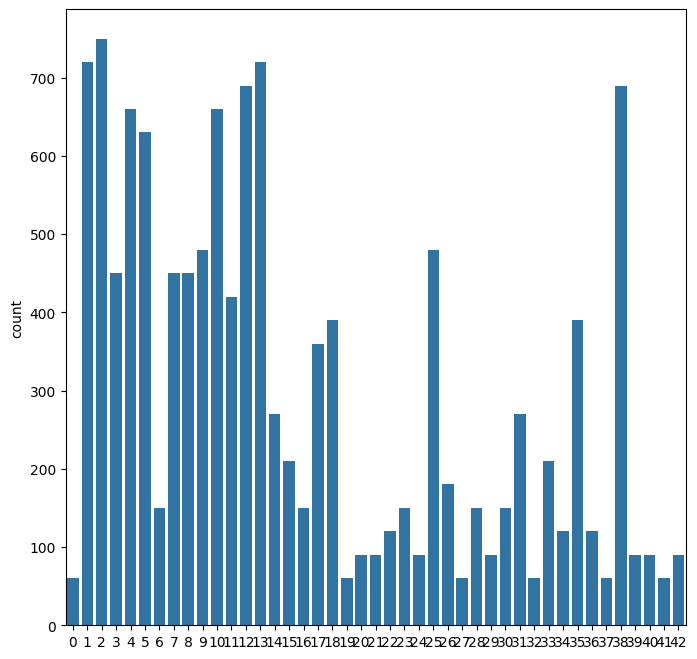

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x=test_labels)

In [ ]:
# Balanced accuracy computation
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [ ]:
metrics = {
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score
}
training_metrics = eval_metrics(softmax_classifier, training_images, training_labels, 256, metrics, desc="Training Eval")
test_metrics = eval_metrics(softmax_classifier, test_images, test_labels, 256, metrics, desc="Test Eval")
print(f"Training metrics: {training_metrics}")
print(f"Test metrics: {test_metrics}")

Training Eval:   0%|          | 0/136 [00:00<?, ?it/s]

Test Eval:   0%|          | 0/50 [00:00<?, ?it/s]

Training metrics: {'accuracy': 0.44291502629385904, 'balanced_accuracy': 0.3577631644125695}
Test metrics: {'accuracy': 0.3926365795724466, 'balanced_accuracy': 0.2937192493403312}


### What now?

They are two possibilities to go forward:

1. We trust in our current model, and we decide to fine-tune hyperparameters such as the batch size or the learning rate. This will require the use of a validation set to find optimal parameters.
2. We decide that a linear classifier acting directly on pixels is probably not that great of an idea to begin with, and we decide to go deeper!

Guess what, we'll go for option 2!

## Going Deeper: Multi-Layer Classifier

In this section, we'll redo much of the same work as for the single layer classification but, now that we know how things work under the hood, we'll rely a lot more on PyTorch to do things for us!

Our first model was nothing else than a softmax activation function stacked on top of a linear layer. The next one will exploit the same idea by stacking multiple layers on top.

The architecture will be as follows:

- Input $x$ of shape (B,32,32,3)
- Layer 1: Linear layer (aka fully-connected) with 100 neurons with biases, followed by ReLU activation ($32*32*3*100 + 100$ learnable weights)
- Layer 2: Linear layer with 75 neurons with biases, followed by ReLU activation ($100*75+75$ learnable weights)
- Output Layer: Linear layer with 43 neurons with biases followed by softmax activation ($75*43+43$ learnable weights)

Where $B$ is the batch size.




### PyTorch, batteries included

This time around, we will be using PyTorch's built-in layers, instead of creating them by hand like the first time. For reference, we could have simply implemented our previous model as:

```
softmax_classifier = nn.Sequential(nn.Flatten(), nn.Linear(32*32*3, 43), nn.Softmax())
```

We will also keep relying on the GPU for our model's computation using `.cuda()` to move tensor to the GPU.

Start the following cell to start training the model, and take your time to go over the code. There are no new concept, but this is now implemented using more of PyTorch's utilities.


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# PyTorch has utilities for dealing with datasets that extend its Dataset class
# It will be able to automatically load in batches and in parallel.
# In this toy example, the whole dataset fits in memory, but in most application,
# the whole dataset can weight 100GB+, so loading it in parallel makes a big difference.
class TrafficSignsDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    images, labels = load_data(path)
    images = images.transpose((0,3,1,2)) # PyTorch expects image data in (channel,height,width) format instead of the usual (height,width,channel)
    self.images = torch.from_numpy(images).cuda() # Send data to GPU memory
    self.labels = torch.from_numpy(labels).cuda()
  def __len__(self):
    return len(self.images)
  def __getitem__(self, idx):
    return self.images[idx], self.labels[idx]

# Training loop
batch_size = 256
training_dataset = TrafficSignsDataset(traffic_signs_dir/"train.p")
validation_dataset = TrafficSignsDataset(traffic_signs_dir/"valid.p")
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

def predict_batch(model, batch_images, no_grad: bool):
  if no_grad:
    with torch.no_grad():
      class_probs = model(batch_images)
  else:
      class_probs = model(batch_images)
  class_labels = torch.argmax(class_probs, dim=1)
  return class_probs, class_labels

def eval_metrics(pred_labels, true_labels, prefix):
    metrics = {
      f"{prefix}accuracy": accuracy_score,
      f"{prefix}balanced_accuracy": balanced_accuracy_score
    }
    return { name: metric_fn(true_labels,pred_labels) for name, metric_fn in metrics.items() }

def train_model(model, training_loader, validation_loader, num_epochs, learning_rate):
  # Loss, optimizer and metrics
  loss_function = torch.nn.NLLLoss() # Negative Log-Likelihood loss function
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # We'll use a built-in optimizer implementation this time

  pbar = tqdm(range(num_epochs),desc="Epochs")

  for epoch in pbar:
    # Training
    train_losses = []
    train_true_labels = []
    train_pred_labels = []

    for batch_idx, (batch_images, batch_labels) in enumerate(training_loader):
      # Loss computation
      class_probs, class_labels = predict_batch(model, batch_images, no_grad=False)
      class_log_probs = torch.log(class_probs+1e-7)
      train_true_labels.append(batch_labels.cpu().numpy())
      train_pred_labels.append(class_labels.cpu().numpy())
      loss = loss_function(class_log_probs, batch_labels)
      train_losses.append(loss.item())
      # SGD Step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    # Evaluation
    # Because Google lets us use pretty big GPUs for free,
    # we can predict the whole validation set at once!
    # This if of course almost never possible on larger datasets and in practice
    # we'd have to use a validation dataloader like for the training set
    _, val_class_labels = predict_batch(model, validation_dataset.images, no_grad=True)
    val_metrics = eval_metrics(
        val_class_labels.cpu().numpy(), # Send results GPU -> CPU memory
        validation_dataset.labels.cpu().numpy(),
        prefix="val_")
    train_metrics = eval_metrics(
        np.hstack(train_pred_labels),
        np.hstack(train_true_labels),
        prefix="train_")
    train_metrics["train_loss"] = np.mean(train_losses)
    pbar.set_postfix({**train_metrics, **val_metrics})

# Define the model
deep_softmax_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 100), nn.ReLU(),
    nn.Linear(100, 75), nn.ReLU(),
    nn.Linear(75, 43), nn.Softmax(dim=1),
).cuda() # Send model to GPU memory

# Start training
train_model(deep_softmax_classifier, training_loader, validation_loader, num_epochs=150, learning_rate=1e-2)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

The validation accuracy should now be closer to 85%, which is a nice improvement! You're also probably observing a much higher training accuracy, which is a sign of overfitting!

Let's see if we can do even better if we stop considering all pixels independently: enter convolutions!

## Making things more Convoluted

Now that we are familiar with Linear layers, it's time to discover another type of layer: the extremely popular Convolutional Layer.

We will use these layers as a "feature extractor":

- Instead of using `Flatten` directly on the input pixels like we've done so far, these pixels will first be pre-processed by a few Conv layers, and we will flatten their output to a (B,512) vector
- The next layers will be the usual Linear layers, the only difference is that they don't operate on raw pixels anymore.

You can start out by adding 2 Linear layers and train the model. You should get very good training performance, but your model will likely overfit. Your job for assignment 1 will be to tweak both the architecture and the learning strategy in order to improve this.

In [ ]:
# A typical CNN classifier
# We will discuss how this works in next week's class.
# For this assignment, use it as-is
# If you know Convolutional layers already, feel free to tweak it as much as you want
# but it's not necessary to complete the assignment!
feature_extractor = nn.Sequential(
    nn.Conv2d(3, 24, kernel_size=(6,6)), nn.ReLU(),
    nn.Conv2d(24, 36, kernel_size=(6,6)), nn.ReLU(),
    nn.Conv2d(36, 48, kernel_size=(4,4), stride=2), nn.ReLU(),
    nn.Conv2d(48, 64, kernel_size=(4,4), stride=2), nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(2,2), stride=2), nn.ReLU(),
)

conv_classifier = nn.Sequential(
    feature_extractor, # Extracts useful features
    nn.Flatten(), # Flatten all features into a single vector of dim (B,512)
    nn.Linear(512, 256), nn.ReLU(),
    nn.Linear(256, 128), nn.ReLU(),
    #nn.Linear(128, 64), nn.ReLU(),
    #nn.Linear(64, 43), nn.Softmax(dim=1) # More precise by deleting one intermediary step, surely cause of overfitting
    nn.Linear(128, 43), nn.Softmax(dim=1)
).cuda() # Send model to GPU memory

# Start training
train_model(conv_classifier, training_loader, validation_loader, num_epochs=100, learning_rate=3e-2)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

## Assignment (Part One - Classification)

Your assignment is to build on the last model to further improve
performance. There are several ways you can improve what we have done so far:

- **Model Architecture**: Add more layers or remove some. If you're not familiar with Convolutional Layers, leave the feature extractor part untouched.
- **Regularization**: Early Stopping, Dropout layers, Batch Normalization, ...
- **Data Augmentation**: Dynamically modify training inputs in ways that don't change the output class that should be predicted, so that the classifier learns to deal with variations in the input. There are hundreds of ways to proceed, eg. by changing contrast, lightly blurring images, flipping them horizontally, taking crops, adding light noise on them, ... Be creative! A combination of search engine use and the `transform` module of the `torchvision` library might be very helpful for this. You can implement this in a flexible way by simply adding an `augment(x)` functiont that applies a random augmentation on a batch `x` and call it inside the training loop.
- **Hyperparameter Tuning**: Try to tweak the learning rate and batch size, using the validation set performance to guide your search. You can also experiment with the parameters of the SGD optimizer, or even try different optimizers altogether.

You should aim the best possible accuracy on the test set (95%+ is a good milestone). Of course, you should not use performance on the test set to tune your model, only the validation set. The test set should only be touched once you're satisfied of the performance of your model on the training and validation sets.

Once you're satisfied with your model, **answer the following questions by adding code and text cells below these instructions.**

- Show at least 5 test samples where your model guesses the wrong class. What are the 5 most probable classes according to your model for these examples?
- Are there classification mistakes that are more common than others? To assess this, plot a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html). Are these mistakes similar to mistakes a human could do?
- Show the learning curves (loss values evolution with training epochs) on training and validation sets. What do these curve tell you?

Once you're ready to submit, create an individual code cell at the end of this notebook. This cell should be self-contained and create an instance of your model, restore your saved weights, and make predictions on the test set. For instructions on how to save/restore weights, see the [PyTorch Documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

At the end of this module, send this model's weight alongside the rest of the project.


## SOMES EXPLAINATIONS / Notes by Maxence

To explain what I did step by step, I have make several cases of code, which one adding (or deleting) layers / hyperpameters / optimizer / data-preprocessing.

Resume :

- Step 1 : Add BatchNorm2D
- Step 2 : Add Dropout
- Step 3 : Add Early Stopping
- Step 4 : Test hyperparameters & optimizer (Adam is one of the most famous)
- Step 5 : Add Data Augmentation (normally very important)

## 1st Step : BatchNorm2D

BatchNorm is a learning technique that normalizes the intermediate outputs of a convolutional layer. It is often used after a convolution to stabilise learning and speed up convergence.

How does it work?

When the activations of a neural network fall within wide intervals (which can happen when things are left to chance), this disrupts the learning process. Why should this happen?

Because by using gradient descent, we expose ourselves to 2 risks: gradient exploding and gradient vanishing.

The formula for gradient descent is :  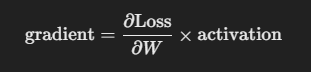

### Gradient EXPLODING :

If the activations are high, the gradients can become too large! Learning will explode towards infinite values!

### Gradient VANISHING :

If, during activation, non-linear functions such as sigmoid or tanh are used, you should be aware that these functions saturate for inputs that are too large or too small.

This means that their derivatives will tend towards 0!

When the gradient is close to 0, the weights no longer evolve, and learning slows down or even stops completely.

The SOLUTION is therefore to have activations centred around 0 (ex: 0.2, -0.3, 0.12, -0.78 etc...) with a low variance such as in the interval [-1, 1] to keep the gradients stable!

### Improves convergence speed!

As well as stabilising the network, it improves the speed of convergence! Because when activations are small, gradients are also smaller, and weight updates are moderate!

This avoids excessive jumps!

Intuitive example: If you want to go down a mountain (gradient descent), ‘moderate and constant steps’ allow you to reach your destination without stumbling. If the steps are too big (huge activations), you risk overshooting the valley or falling!

### Best GENERALIZATION

That's what we want! When activations are centred around 0 and with a low variance, the model becomes more regular. So it performs better on new data.

Why should this be?

Because very large or unbalanced activations create models that are more sensitive to data noise.

With stable activations, the model becomes less biased by aberrant or unexpected inputs.

In [ ]:
feature_extractor = nn.Sequential(
    nn.Conv2d(3, 24, kernel_size=(6,6)), nn.ReLU(),

    # Test bby reading the doc : https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html. It's useful to stabilize learning, and increase or decrease the number of neurons in the fully connected layers.
    nn.BatchNorm2d(24),

    nn.Conv2d(24, 36, kernel_size=(6,6)), nn.ReLU(),
    nn.Conv2d(36, 48, kernel_size=(4,4), stride=2), nn.ReLU(),

    # Test bby reading the doc : https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html. It's useful to stabilize learning, and increase or decrease the number of neurons in the fully connected layers.
    nn.BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

    nn.Conv2d(48, 64, kernel_size=(4,4), stride=2), nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(2,2), stride=2), nn.ReLU(),
)

conv_classifier = nn.Sequential(
    feature_extractor, # Extracts useful features
    nn.Flatten(), # Flatten all features into a single vector of dim (B,512)
    nn.Linear(512, 256), nn.ReLU(),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Linear(128, 43), nn.Softmax(dim=1)
).cuda() # Send model to GPU memory

# Start training
train_model(conv_classifier, training_loader, validation_loader, num_epochs=100, learning_rate=3e-2)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

## Step 1 : BacthNorm2D RESULT

Just by applying a BatchNorm2D to normalise the activation values, we end up with the following values:
val_accuracy=0.959
val_balanced_accuracy=0.935



## Step 2 : Dropout

Dropout is a regularisation technique to reduce overfitting!

Overfitting is when the neural network learns the training data too well, to the point of memorising every detail or noise, and the consequence is that the model knows the training data by heart (and therefore gives good results) but is useless when it has to adapt to new data!

Dropout will simply randomly deactivate a percentage of neurons during training, to prevent the model from being too dependent on certain neurons!

Since different parts of the network will be deactivated at each iteration, the model will become more robust in the face of data variations (it will already be used to having a random % of neurons deactivated!).

In [ ]:
feature_extractor = nn.Sequential(
    nn.Conv2d(3, 24, kernel_size=(6,6)), nn.ReLU(),

    # Test by reading the doc : https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html. It's useful to stabilize learning.
    nn.BatchNorm2d(24),

    nn.Conv2d(24, 36, kernel_size=(6,6)), nn.ReLU(),
    nn.Conv2d(36, 48, kernel_size=(4,4), stride=2), nn.ReLU(),

    # Test by reading the doc : https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html. It's useful to stabilize learning.
    nn.BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

    nn.Conv2d(48, 64, kernel_size=(4,4), stride=2), nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(2,2), stride=2), nn.ReLU(),
)

conv_classifier = nn.Sequential(
    feature_extractor, # Extracts useful features
    nn.Flatten(), # Flatten all features into a single vector of dim (B,512)
    nn.Linear(512, 256), nn.ReLU(),
    nn.Dropout(0.5), # Disable randomly 50% neurons
    nn.Linear(256, 128), nn.ReLU(),
    nn.Dropout(0.5), # Disable randomly 50% neurons
    nn.Linear(128, 43), nn.Softmax(dim=1)
).cuda() # Send model to GPU memory

# Start training
train_model(conv_classifier, training_loader, validation_loader, num_epochs=100, learning_rate=3e-2)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

## Step 2 : DropOut Result

As you can see, the values for train_accuracy (0.999) / train_balanced_accuracy (0.998) and val_accuracy (0.966) / val_balanced_accuracy(0.94) are now closer and less varied!

What's more, we've had another slight increase. Since we obtained :

val_accuracy = 0.966 & val_balanced_accuracy = 0.94

## Step 3 : Early Stopping (Reflexion)

Early Stopping is a dynamic regulation technique to avoid overfitting. Explanation:

At the beginning, the error decreases on both the training data and the validation data. But later, the training error continues to decrease. While the validation error increases. The model no longer generalises well.

Early Stopping simply allows you to stop training as soon as the validation error stops improving, rather than waiting for the total number of epochs.

#### Note: In the end, I don't think I'll be implementing Early Stopping. The model seems to be very well regularised already and we no longer have access to the Google Colab GPU (We've used up our free rate). Let's avoid making the model more complex, and try instead to test with other hyper-parameters.

## Step 4 : Hyperparameters & optimizer



### Add an optimizer : Adam

I don't know if I can change de train_model() function, so I didn't change anything here, I just make my test in my side.

The result are small better, and it's not surprising because Adam is often better than SGD, but it consumes more memory (because it keep in memory the mean of gradients + square of gradients).

Anyway, the result are not too much different with SGD.

### Change the number of epochs + graph :
The idea is to make a big value of number of epoch (300 seems good because it takes 10min so it's not too long) and plot a graph to see when the model stop learning, or decrease learning. After that, we'll can choose an appropriate number of epoch.

But also here, I have to change the train_model() function so I don't know if I can. Anyway, between 80 & 100 the graph start to decrease is learning. So, 100 still a good choice.

## Step 5 : Data Augmentation NOT RUN THE CELLS BELOW (We didn't manage to do exactly and perfectly what we wanted due to lack of time. This was our first time working with ‘.p’ files.)

Very important step in this kind of project.

When we have a lot of labels, often, some of labels are under-represented, and other over-represented.

This is a problem because the model can be very good like 95%. But if he is good for 40 labels that are present 95% of time, and very bad for 3 labels that are present 5% of time, it means that in 1/20 case, the model will be useless !

We have to do something to equalize the representation of each labels. For that, we will use Data Augmentation on under-represented labels.

How it works ? --> A simple example is with text data. If we want to augment the number of toxic comment to better analyse them in a NLP model, we can do some changes of one comment to create variants :

Original Comment : "I freaking hate you, your videos suck !"

Variants :
- I freaking ***really*** hate you, your videos ***completely*** suck ! (Word(s) Insertion(s))

- I hate you, your videos suck ! (Word(s) Deletion(s))

- I freaking hate you, suck your videos ! (Word(s) Swap)

- I hate you, your videos are worthless ! (Back-Translation)


And the result is that instead to have 1 toxic comment, we now have 5. So we multiply the number of data in this label by 5 !


With picture, it's the same way. We can :
- Rotate the pictures
- Flip the pictures
- Random Crop
- Translation (shift the picture)
- Zoom
- Luminosity & Constrast Variation
...


I will use torchvision.transforms to create a personnalize DataLoader which will apply transformation ONLY on under-represented pictures.

In [ ]:
import numpy as np
import pickle
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image

# load datas
images, labels = load_data(traffic_signs_dir / "train.p")



# Label that we want to be augmented (we have checked manually)
targeted_labels = [0, 6, 15, 16, 17, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43]

# Here you can see all data augmentation type that we want to do. Because we are doing 4 transformations (+ the original picture), we do a x5 data augmentation
data_augmentation = T.Compose([
    T.RandomRotation(10), # change rotation
    T.RandomHorizontalFlip(), # flip horizontaly
    T.ColorJitter(brightness=0.2, contrast=0.2), # change a bit the brightness and the contrast
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)), # translate a bit
])

# list to sock images / labels
augmented_images = []
augmented_labels = []

# apply data augmentation
print("Data augmentation in progress...")
for idx, (image, label) in enumerate(tqdm(zip(images, labels), total=len(images))):
    # here we need to verify the shape, we don't know why but all pictures has not the same shape
    if image.shape != (3, 32, 32):  # we want that pictures is in this format, because this is the most common one in the dataset
        image = image[:3, :, :]  
    augmented_images.append(image)
    augmented_labels.append(label)

    # if label is under-represented, we can apply data augmentation
    if label in targeted_labels:
        for _ in range(5):  # we want to generate 5 augmented pictures by under-represented pictures
            # pil conversion
            pil_image = Image.fromarray((image.transpose(1, 2, 0) * 255).astype(np.uint8), mode='RGB')

            # data augmentation
            augmented_image = data_augmentation(pil_image)

            # convert back into tensor-like
            augmented_image = np.array(augmented_image).transpose(2, 0, 1) / 255.0
            if augmented_image.shape == (3, 32, 32):
                augmented_images.append(augmented_image)
                augmented_labels.append(label)
            else:
                print(f"Image ignored because of incorrect shape : {augmented_image.shape}")


# convert into a list of numpy array
augmented_images = np.array(augmented_images, dtype=np.float32)
augmented_labels = np.array(augmented_labels, dtype=np.int64)

# save augmented data into a .p file
output_path = "augmented_train.p"
with open(output_path, "wb") as f:
    pickle.dump({"features": augmented_images, "labels": augmented_labels}, f)

print(f"Augmented data saved in {output_path}")


Augmentation des données en cours...


100%|██████████| 34799/34799 [00:42<00:00, 810.62it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (96744,) + inhomogeneous part.

In [ ]:
from torch.utils.data import DataLoader

class TrafficSignsDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        # load augmented daata from the pickle file
        with open(path, "rb") as f:
            data = pickle.load(f)
        self.images = torch.from_numpy(data["features"]).cuda()
        self.labels = torch.from_numpy(data["labels"]).cuda()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create a new dataset with the augmented datas
augmented_dataset = TrafficSignsDataset("augmented_train.p")

# new DataLoader
augmented_loader = DataLoader(augmented_dataset, batch_size=256, shuffle=True)
print(f"Total number of images in the expanded train dataset : {len(augmented_dataset)}")


FileNotFoundError: [Errno 2] No such file or directory: 'augmented_train.p'

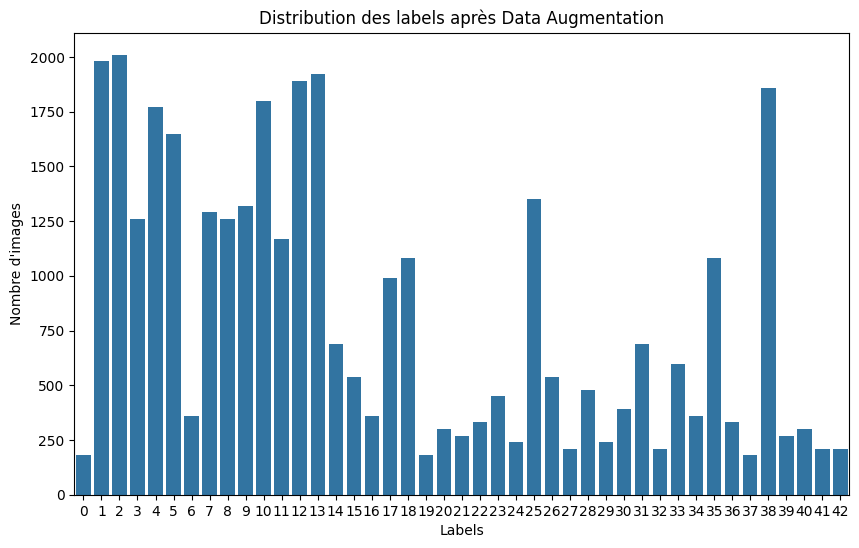

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# new data distribution in labels
augmented_labels = augmented_dataset.labels.cpu().numpy()

plt.figure(figsize=(10, 6))
sns.countplot(x=augmented_labels)
plt.title("Label distribution after Data Augmentation")
plt.xlabel("Labels")
plt.ylabel("Number of images")
plt.show()

## TEST OUR MODEL USING THE AUGMENTED DATASET

This was our 1st time managing ‘.p’ files and we didn't manage to get the labels we wanted. We tried a number of different ways but it was impossible, all the labels increased, which didn't help at all as the principle was to equalise the data. We could do with a note explaining how to do this.

## ANSWERING THE QUESTIONS


- Show at least 5 test samples where your model guesses the wrong class. What are the 5 most probable classes according to your model for these examples?


In [ ]:
from torch.nn.functional import softmax
import matplotlib.pyplot as plt

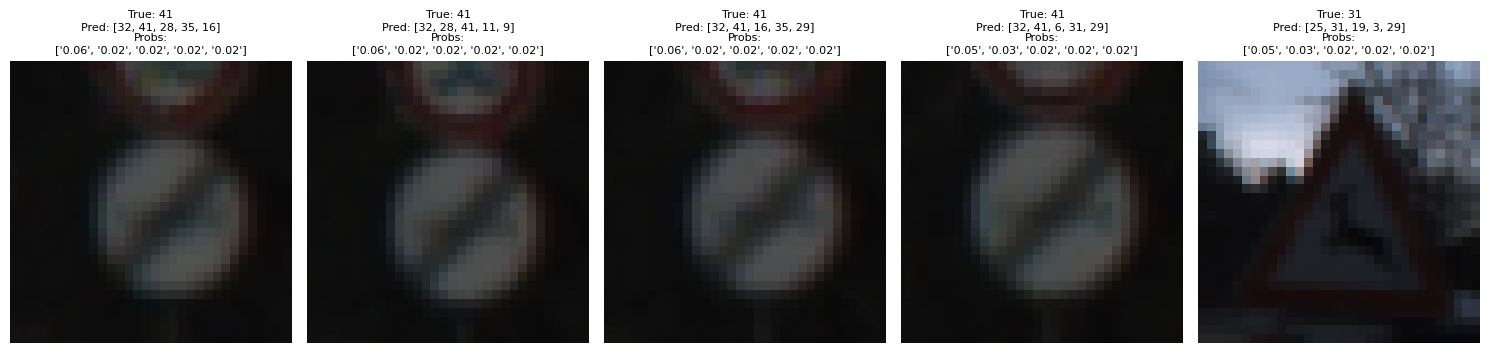

In [ ]:
def show_misclassified_examples(model, data_loader, num_examples=5):
    model.eval()  # model in evaluation mode
    misclassified = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            probs = softmax(outputs, dim=1)
            predicted = torch.argmax(probs, dim=1)

            # identify the bad precitions
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu(), probs[i].cpu()))

                if len(misclassified) >= num_examples:
                    break
            if len(misclassified) >= num_examples:
                break

    # print the misclassified examples
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    for idx, (image, true_label, prob) in enumerate(misclassified):
        ax = axes[idx]
        ax.imshow(image.permute(1, 2, 0))  # swap axes for display
        ax.axis("off")

        # extract the 5 most probable classes and their probabilities
        top5 = torch.topk(prob, 5)
        top5_indices = top5.indices.tolist()
        top5_values = [f"{p:.2f}" for p in top5.values.tolist()]  # limitation to 2 decimals

        # title + infos
        title = f"True: {true_label}\nPred: {top5_indices}\nProbs:\n{top5_values}"
        ax.set_title(title, fontsize=8)

    plt.tight_layout()
    plt.show()

show_misclassified_examples(conv_classifier, validation_loader)


In most cases, the true class appears in the top 5 predictions, but lacks confidence!  For example, class 41, which is true 4 times, is always confused with class 32. The dataset should be balanced between these 2 data sets to enable the model to see the differences between these 2 classes.

- Are there classification mistakes that are more common than others? To assess this, plot a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html). Are these mistakes similar to mistakes a human could do?

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

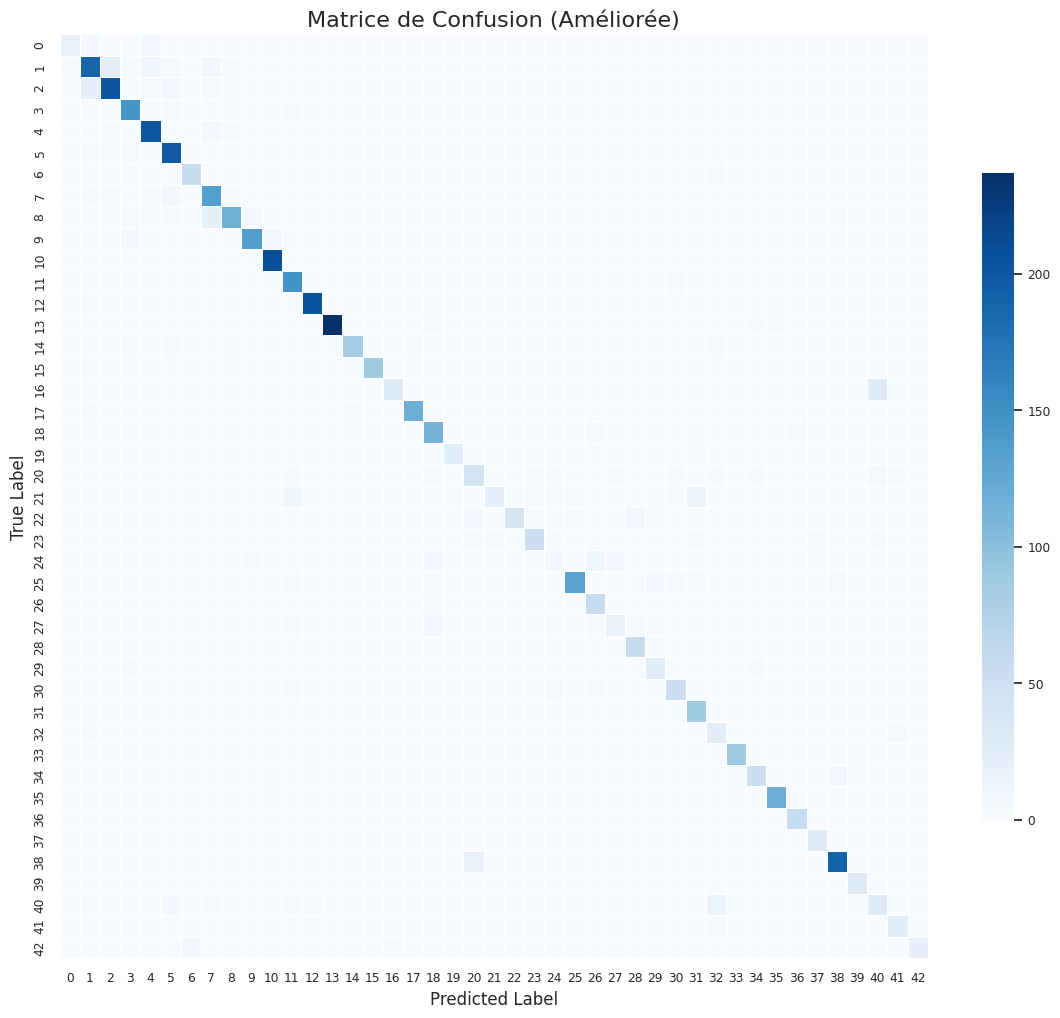

In [ ]:
def get_predictions(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.cuda()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Calculating and displaying the confusion matrix
preds, true_labels = get_predictions(conv_classifier, validation_loader)

# confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# displaying 
plt.figure(figsize=(14, 12))  # big size
sns.set(font_scale=0.8)  # font size
ax = sns.heatmap(
    conf_matrix,
    annot=False,  # disable annotations
    cmap='Blues',  # blue is a common color for confusion matrix
    linewidths=0.5,  # line adding for better visibility
    linecolor='white',
    cbar_kws={'shrink': 0.7}  # legend size
)

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()


The diagonal clearly shows that our model classifies correctly. However, a few dark boxes show that there are recognition problems between certain classes.

For example:
- Between the label 41 and 16.
- Between label 20 and 38
- Between label 32 and 40

In all 3 ‘pairs’ there is at least one under-represented class. Data Augmentation should be able to solve this problem.

- Show the learning curves (loss values evolution with training epochs) on training and validation sets. What do these curve tell you?

In [ ]:
def train_model(model, training_loader, validation_loader, num_epochs, learning_rate):
    # loss, optimizer and metrics
    loss_function = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    history = {"train_loss": [], "val_loss": []}  # loss history

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for images, labels in training_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            log_probs = torch.log(outputs + 1e-7)
            loss = loss_function(log_probs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # val
        model.eval()
        val_losses = []
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                log_probs = torch.log(outputs + 1e-7)
                loss = loss_function(log_probs, labels)
                val_losses.append(loss.item())

        # save losses
        history["train_loss"].append(np.mean(train_losses))
        history["val_loss"].append(np.mean(val_losses))
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}")

    return history


In [ ]:
history = train_model(conv_classifier, training_loader, validation_loader, num_epochs=100, learning_rate=3e-2)


Epoch 1/100 - Train Loss: 15.2959, Val Loss: 15.3836
Epoch 2/100 - Train Loss: 15.2968, Val Loss: 15.3836
Epoch 3/100 - Train Loss: 15.3001, Val Loss: 15.3836
Epoch 4/100 - Train Loss: 15.2982, Val Loss: 15.3836
Epoch 5/100 - Train Loss: 15.2977, Val Loss: 15.3836
Epoch 6/100 - Train Loss: 15.2991, Val Loss: 15.3836
Epoch 7/100 - Train Loss: 15.2968, Val Loss: 15.3836
Epoch 8/100 - Train Loss: 15.2987, Val Loss: 15.3836
Epoch 9/100 - Train Loss: 15.2991, Val Loss: 15.3836
Epoch 10/100 - Train Loss: 15.3019, Val Loss: 15.3836
Epoch 11/100 - Train Loss: 15.2991, Val Loss: 15.3836
Epoch 12/100 - Train Loss: 15.2996, Val Loss: 15.3836
Epoch 13/100 - Train Loss: 15.3001, Val Loss: 15.3836
Epoch 14/100 - Train Loss: 15.2963, Val Loss: 15.3836
Epoch 15/100 - Train Loss: 15.2982, Val Loss: 15.3836
Epoch 16/100 - Train Loss: 15.2996, Val Loss: 15.3836
Epoch 17/100 - Train Loss: 15.3019, Val Loss: 15.3836
Epoch 18/100 - Train Loss: 15.2973, Val Loss: 15.3836
Epoch 19/100 - Train Loss: 15.2973, V

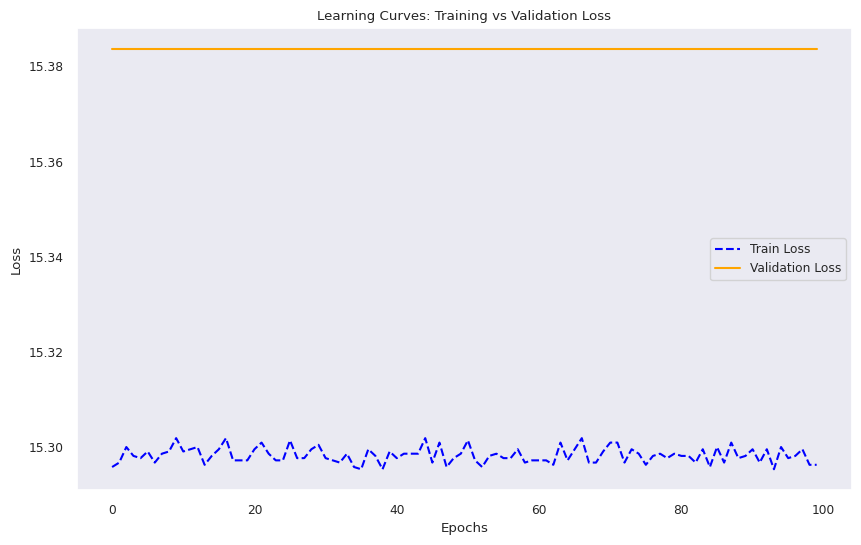

In [ ]:
import matplotlib.pyplot as plt

# Tdraw learning curves
plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label="Train Loss", color="blue", linestyle="--")
plt.plot(history["val_loss"], label="Validation Loss", color="orange", linestyle="-")
plt.title("Learning Curves: Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

### Note by Maxence

1. The blue curve represents the evolution of the loss over the training set.
2. The orange curve represents the evolution of the loss over the validation set.

- If both curves decrease progressively, the model is learning correctly.
- If the validation loss stagnates or increases while the training loss decreases, this is a sign of overlearning.
- If both curves stagnate at high values, the model is underlearning.

This helps to adjust hyperparameters such as :

The learning rate.
The number of epochs.
Model complexity (more layers, more neurons).
Regularisation (Dropout, BatchNorm, Early Stopping, etc.).

## Assignment (Part two - Fine-tuning)

Now that we have successfully built our own CNN, we made a good image classification model, but we can still make it better. Moreover, for the perception module of an autonomous vehicle, the application we are aiming for is not classification, but detection. We don't want to classify every frame 'seen' by our vehicle, but we want to detect important objects around us, like cars or traffic lights.

We will use the state of the art by importing a pre-trained YOLO model, and fine-tune it on a CARLA dataset.

Let's start by using the model directly off-the-shelf and see how it performs.

In [23]:
#RUN THIS CELL IF ULTRALYTICS IS NOT INSTALLED YET
#!pip install ultralytics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 38.8M/38.8M [00:00<00:00, 49.9MB/s]


Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11m summary (fused): 303 layers, 20,091,712 parameters, 0 gradients, 68.0 GFLOPs

Dataset 'coco8.yaml' images not found ⚠️, missing path '/content/datasets/coco8/images/val'


100%|██████████| 433k/433k [00:00<00:00, 83.6MB/s]
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100%|██████████| 25/25 [00:00<00:00, 3796.57file/s]

Dataset download success ✅ (1.6s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 126MB/s]
val: Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 130.97it/s]

val: New cache created: /content/datasets/coco8/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


                   all          4         17      0.766      0.966      0.942      0.772
                person          3         10          1      0.795      0.845      0.543
                   dog          1          1      0.766          1      0.995      0.895
                 horse          1          2        0.8          1      0.995      0.705
              elephant          1          2      0.643          1      0.828      0.597
              umbrella          1          1      0.667          1      0.995      0.995
          potted plant          1          1      0.721          1      0.995      0.895
Speed: 1.2ms preprocess, 17.6ms inference, 0.0ms loss, 150.1ms postprocess per image
Results saved to runs/detect/val



100%|██████████| 134k/134k [00:00<00:00, 34.1MB/s]

image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 59.4ms
Speed: 2.4ms preprocess, 59.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


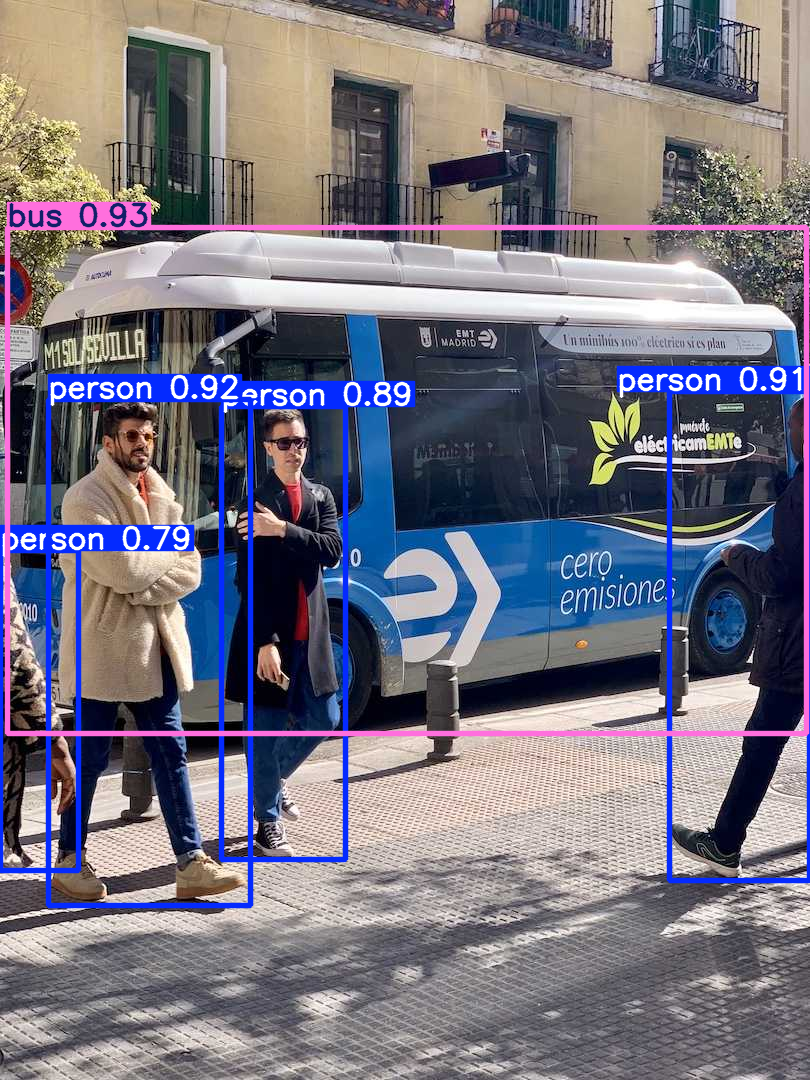

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLO model
model = YOLO("yolo11m.pt")
# There are 5 different versions of YOLO11 which we can use, from n to x. Yolo11n is smaller and faster, but also less precise.
# Yolo11x is bigger and more powerful, but also more ressource expensive.
#   -yolo11n
#   -yolo11s
#   -yolo11m
#   -yolo11l
#   -yolo11x
# yolo11m is a good compromise between speed and precision.


# Evaluate the model's performance on the validation set
results = model.val(data="coco8.yaml")

# Perform object detection on an image using the model
results = model("https://ultralytics.com/images/bus.jpg")

#Here are a few useful methods to get the results of your model.
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen


### To see differences between all YOLO versions, I have copy/pase code to have all examples in the same window

### YOLO11n

100%|██████████| 5.35M/5.35M [00:00<00:00, 308MB/s]

Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)


YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


                   all          4         17       0.57       0.85      0.847      0.632
                person          3         10      0.557        0.6      0.585      0.272
                   dog          1          1      0.548          1      0.995      0.697
                 horse          1          2      0.529          1      0.995      0.674
              elephant          1          2       0.37        0.5      0.516      0.256
              umbrella          1          1      0.568          1      0.995      0.995
          potted plant          1          1      0.846          1      0.995      0.895
Speed: 0.2ms preprocess, 28.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val2

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 49.5ms
Speed: 3.5ms preprocess, 49.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


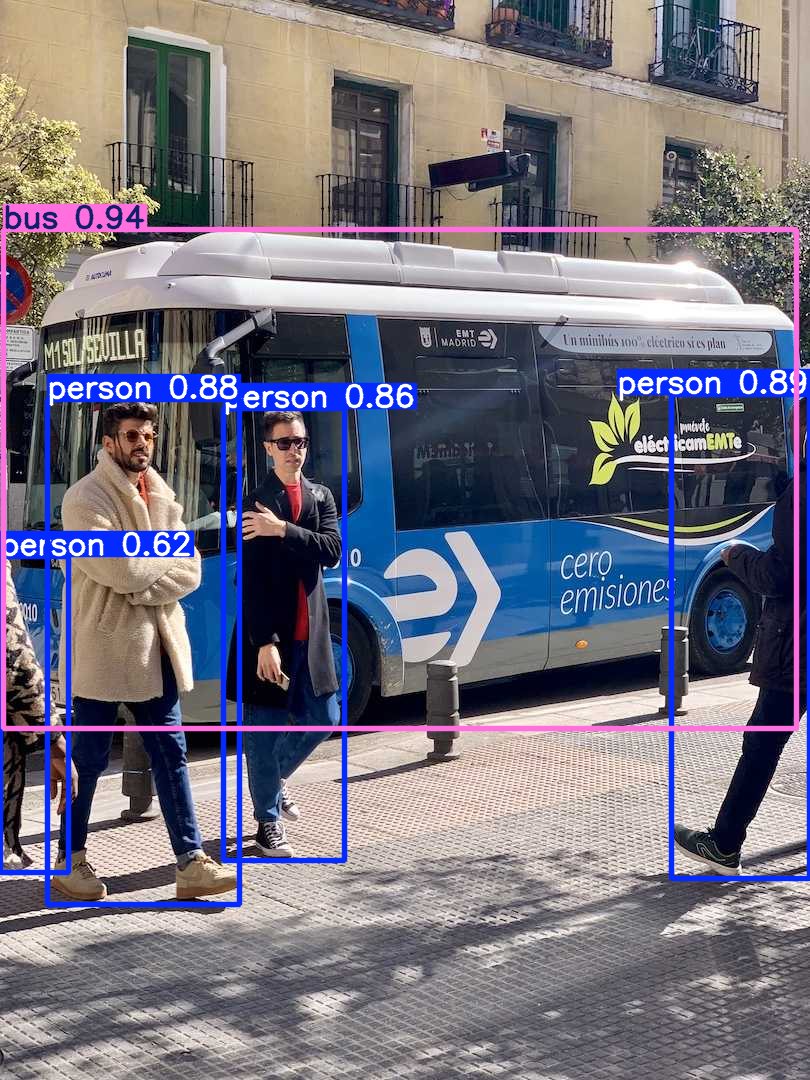

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLO model
model = YOLO("yolo11n.pt")
# There are 5 different versions of YOLO11 which we can use, from n to x. Yolo11n is smaller and faster, but also less precise.
# Yolo11x is bigger and more powerful, but also more ressource expensive.
#   -yolo11n
#   -yolo11s
#   -yolo11m
#   -yolo11l
#   -yolo11x
# yolo11m is a good compromise between speed and precision.


# Evaluate the model's performance on the validation set
results = model.val(data="coco8.yaml")

# Perform object detection on an image using the model
results = model("https://ultralytics.com/images/bus.jpg")

#Here are a few useful methods to get the results of your model.
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen


### YOLO11x

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLO model
model = YOLO("yolo11x.pt")
# There are 5 different versions of YOLO11 which we can use, from n to x. Yolo11n is smaller and faster, but also less precise.
# Yolo11x is bigger and more powerful, but also more ressource expensive.
#   -yolo11n
#   -yolo11s
#   -yolo11m
#   -yolo11l
#   -yolo11x
# yolo11m is a good compromise between speed and precision.


# Evaluate the model's performance on the validation set
results = model.val(data="coco8.yaml")

# Perform object detection on an image using the model
results = model("https://ultralytics.com/images/bus.jpg")

#Here are a few useful methods to get the results of your model.
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen


ModuleNotFoundError: No module named 'ultralytics'

### ANSWERS

- Try importing some of the other YOLO models in the cell above. What changes in the output can you see between different versions ?
- How many parameters are there in Yolo11n ? Yolo11x ?

For the 1st question, we can see that YOLO11n has a lower execution time, but is less accurate (0.62 instead of 0.79 for one of the people).

YOLO11m has high probabilities for all objects. It is fairly complete.

Finally, YOLO11x took the longest of the 3, and strangely enough did not perform any better in our case than YOLO11m.

In [ ]:
model = YOLO("yolo11x.pt")
model.info()

YOLO11x summary: 631 layers, 56,966,176 parameters, 0 gradients, 196.0 GFLOPs


(631, 56966176, 0, 195.9587328)

In [ ]:
model = YOLO("yolo11n.pt")
model.info()

YOLO11n summary: 319 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(319, 2624080, 0, 6.614336)

For the 2nd question, we can see for YOLO11n :
- Number of parameters: 2,624,080
- Number of layers: 319
- GFLOPs (floating point operations): 6.6

For YOLO11x :
- Number of parameters: 56,966,176
- Number of layers: 631
- GFLOPs (floating point operations): 196.0

The pre-trained YOLO11 model was trained on the COCO dataset containing real images, which reduce its performance when applied to our simulation scenario. To improve it, we want to fine-tune it on a CARLA dataset.

Moreover, the YOLO11 model that we are using is trained on 80 different classes. Some of them are very useful for us like detecting cars, bus and traffic lights but some are not relevant for us. Most importantly, there are classes which we want to detect that are not present in the original dataset used to train YOLO, like traffic light colors !

For our autonmous driving application, we need a dataset containing images collected in the CARLA simulation environment but also labels that reflect the specific things we need to detect.

You can find our custom dataset at : https://app.roboflow.com/carla-test/modified-carla/3

Download the last version in the YOLO11 format and upload the zip file to your google collab notebook.

### Note by Maxence
#### What is Fine Tuning?

Fine-tuning consists of :
- Reusing the weights of a pre-tuned model (YOLO11 on COCO) as a **starting point**.
- Continuing training on a new specific dataset (CARLA dataset) to :
  - Adapt the model to a new environment (simulation)
  - Learn new classes not present in the original dataset.

Why is the CARLA dataset important here?
- It better reflects the needs of your application (detection of cars, traffic lights in a simulated environment).
- It contains labels specific to autonomous driving that the COCO dataset does not have, such as the colours of traffic lights.
- This improves the accuracy of the model in our use case.

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from pathlib import Path

traffic_signs_dir = Path("/content") / "datasets"
traffic_signs_dir.mkdir(parents=True, exist_ok=True)
print(f"Extracting the custom dataset")

!unzip Custom.zip -d /content/datasets/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: /content/datasets/train/images/Town03_017640_png.rf.cb6cd02bcfe447cc0e9c6f8d8b1d1783.jpg  
 extracting: /content/datasets/train/images/Town03_017660_png.rf.2ff86b9537f2561bf59e25962b1b2640.jpg  
 extracting: /content/datasets/train/images/Town03_017660_png.rf.42abf71bce54b30b28f69873299fdbe5.jpg  
 extracting: /content/datasets/train/images/Town03_017660_png.rf.7fbfc254de87eb8fc4da7363304a3e71.jpg  
 extracting: /content/datasets/train/images/Town03_017680_png.rf.56af4dbdd2069f9c41f251f3d8dc49cd.jpg  
 extracting: /content/datasets/train/images/Town03_017680_png.rf.ac7ce4bc86eab1209c38eb7b935cdac5.jpg  
 extracting: /content/datasets/train/images/Town03_017680_png.rf.ad1032c05e3c731007fd73af7eb2f54f.jpg  
 extracting: /content/datasets/train/images/Town03_017740_png.rf.0187f29f2d259f5d58e276541f97fee4.jpg  
 extracting: /content/datasets/train/images/Town03_017740_png.rf.39d8abab60f1f942e27692907

Nombre d'annotations pour chaque label :
vehicle: 3456
red_light: 3270
bike: 447
green_light: 948
motobike: 231
traffic_light: 243
yellow_light: 96
traffic_sign: 282


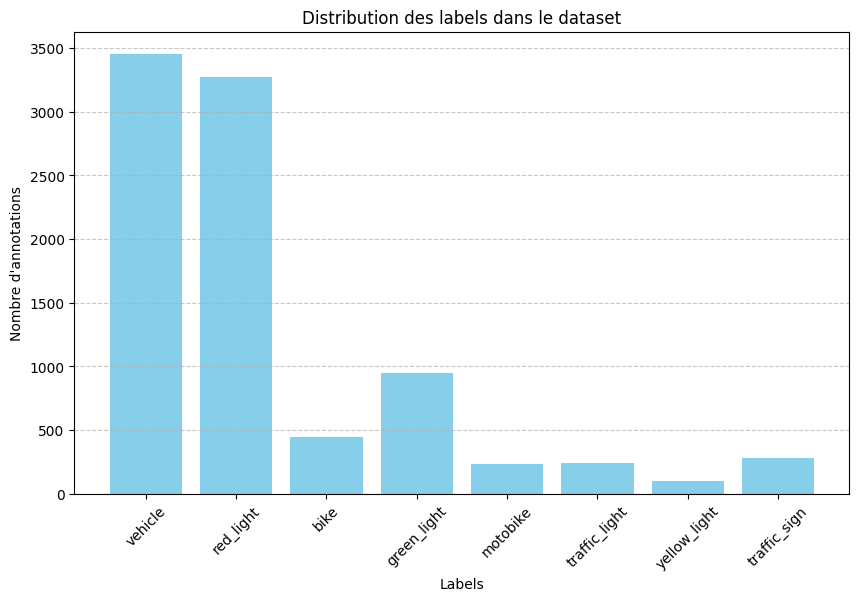

In [4]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

labels_dir = "/content/datasets/train/labels"

# dictionary to count labels
label_count = defaultdict(int)

# browse YOLO annotation files
for file in os.listdir(labels_dir):
    if file.endswith(".txt"):  # YOLO annotations are in .txt files
        with open(os.path.join(labels_dir, file), "r") as f:
            for line in f:
                label_id = int(line.split()[0])  # this is the ID of the label
                label_count[label_id] += 1

# display result with label's name
label_names = ['bike', 'green_light', 'motobike', 'red_light',
               'traffic_light', 'traffic_sign', 'vehicle', 'yellow_light']

# list of labels and account
labels = [label_names[label_id] for label_id in label_count.keys()]
counts = [label_count[label_id] for label_id in label_count.keys()]

print("Number of annotations for each label:")
for label, count in zip(labels, counts):
    print(f"{label}: {count}")

# display
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.title("Distribution of labels in the dataset")
plt.xlabel("Labels")
plt.ylabel("Number of annotations")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- What do you notice about the label distribution ?
- In you opinion, could this be an issue for our application ?

### ANSWERS

For the 1st question:

We see a very big difference in the distribution of labels. Vehicle and Red Light have more than 3000 annotations, while all the others have less than 1000 annotations. There is a distributivity problem.

For the 2nd question:

Yes! This could be a problem.

This is called "Class Imbalance" and can be misleading with overly optimistic scores. Data augmentation is needed to solve this problem.

Now we train the model on our traffic light dataset

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
#Save path to our dataset. If nothing is specified, utltralytics loads the coco8 dataset
path = "datasets/data.yaml"

# Train the model for a few epochs
results = model.train(data=path, epochs=3, warmup_epochs=0, pretrained=True)

# Evaluate the model's performance on the validation set
results = model.val()

# Perform object detection on an image using the model
results = model("https://ultralytics.com/images/bus.jpg")

# Save the model
success = model.save("./yolo_collab_tuned.pt")

Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=datasets/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /content/datasets/train/labels... 3183 images, 321 backgrounds, 0 corrupt: 100%|██████████| 3183/3183 [00:02<00:00, 1241.87it/s]


train: New cache created: /content/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/valid/labels... 270 images, 35 backgrounds, 0 corrupt: 100%|██████████| 270/270 [00:00<00:00, 1024.07it/s]

val: New cache created: /content/datasets/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      2.46G      1.228      2.358      1.263         81        640: 100%|██████████| 199/199 [00:23<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


                   all        270       1709      0.606      0.255      0.273      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      2.62G     0.9935      1.364      1.125         70        640: 100%|██████████| 199/199 [00:21<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.65it/s]

                   all        270       1709       0.57      0.317      0.335      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      2.65G     0.8864      1.102      1.061         56        640: 100%|██████████| 199/199 [00:21<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.55it/s]

                   all        270       1709      0.743      0.371      0.397      0.235



3 epochs completed in 0.021 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n summary (fused): 238 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]


                   all        270       1709      0.743      0.371      0.396      0.235
                  bike         25         32      0.567      0.812      0.692      0.402
           green_light         67        181      0.484      0.304      0.352      0.138
              motobike         14         14      0.339      0.357      0.312      0.207
             red_light        165       1194      0.703      0.444      0.558      0.218
         traffic_light         30         34          1          0     0.0728     0.0635
          traffic_sign         11         11          1      0.152      0.221      0.158
               vehicle        131        223      0.855      0.897      0.943      0.683
          yellow_light          7         20          1          0     0.0205    0.00847
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40G

val: Scanning /content/datasets/valid/labels.cache... 270 images, 35 backgrounds, 0 corrupt: 100%|██████████| 270/270 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.63it/s]


                   all        270       1709      0.744      0.371      0.397      0.235
                  bike         25         32      0.563      0.812      0.696      0.402
           green_light         67        181      0.499      0.304      0.352      0.138
              motobike         14         14      0.333      0.357      0.312      0.208
             red_light        165       1194      0.703      0.444      0.555      0.216
         traffic_light         30         34          1          0     0.0738     0.0674
          traffic_sign         11         11          1      0.154      0.221      0.159
               vehicle        131        223      0.854      0.897      0.944      0.683
          yellow_light          7         20          1          0     0.0206    0.00846
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train2

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /conte

Let's take a closer look at all the information Ultralytics is giving us:

- First, you can see information on the pre-trained model your are using: its architecture, number of layer, parameters...

- The line `Overriding model.yaml nc=80 with nc=8` tells us that we are changing the dimension of the final layer of the model with our dataset. While the base Yolo is trained to detect 80 class, we are only using 8.

- For each Epoch, you can see the training process advance with the varying loss decreasing over time.

- The mAP for each classes as well as the confusion matrix give you very good overview of your performance.

You just trained an existing model on our custom dataset. When running the evaluation, Ultralytics provides you with a lot of different metrics in the prompt, and even more which you can find in `run/detect/val_`

#### Notes by Maxence

For each epoch (here 3), we can observe the following metrics:
- box_loss: Losses associated with bouding boxes (precision of predictive boxes)
- cls_loss: Losses for the classification of detected objects.
- dfl_loss: Loss associated with the adjustment of bouding boxes (using a specific regression method)

Instances = the number of objects processed during training.

##### mAP50 and mAP50-95
mAP (Mean Average Precision) is a key metric for object detection models.
- mAP50: Average precision for an IoU >= 50% (Intersection Over Union)
- mAP50-95: Average precision for IoU values ​​between 50% and 95%.

These values ​​increase with each epoch, indicating that the model learns progressively.

#### Notes by Maxence
#### METRICS EXPLANATIONS

We got a lot of metrics in .png format after running YOLO. Here are explanations of each file/metric:

- **val_batch0_labels.jpg** shows the REAL annotations of the images, i.e. the real classes present in each image.

- **val_batch0_pred.jpg** shows the model predictions on the same images. We see the predicted classes and the associated confidence scores.

- **Confusion_matrix.png** shows the absolute number of correct and incorrect predictions for each class.

- **Confusion_matrix_normalized.png** shows the values ​​expressed in percentage (%), which allows to compare performances between classes fairly.

- **R_Curve.png** (= Recall-Confidence Curve) shows the percentage of correctly detected objects according to the confidence threshold. A high curve indicates good recall even at high confidence thresholds.

- **P_curve.png** (= Precision-Confidence Curve) measures the proportion of correct predictions relative to all predictions. An upward-sloping curve shows that the model achieves high precision for high confidence thresholds.

- **PR_curve.png** (= Precision-Recall Curve) Combines precision and recall for different thresholds. A large area under the curve indicates an optimal balance between precision and recall.

- **F1_curve.png** (= F1-Confidence Curve) shows the harmonic mean in precision and recall, used to assess the overall balance. A high curve indicates that the model achieves a good balance between precision and recall over a wide range of confidence thresholds.

In [ ]:
#Put your code here

#Play around the different training parameters of model.train(), add more epochs, and get the best possible model.
#When it starts looking good, import it to CARLA and test it in the simulation !

model = YOLO("yolo11m.pt")

# path to our dataset
path = "datasets/data.yaml"

# hyperparameters
epochs = 40  # epochs
batch_size = 32  #be careful to use A100 GPU from paid version of google colab.
learning_rate = 0.005  # lr
image_size = 640  # picture size for training

# train
results = model.train(
    data=path,
    epochs=epochs,
    batch=batch_size,
    imgsz=image_size,
    lr0=learning_rate,
    warmup_epochs=5,
    pretrained=True  # pre-trained as a base
)

Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=datasets/data.yaml, epochs=40, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

train: Scanning /content/datasets/train/labels.cache... 3183 images, 321 backgrounds, 0 corrupt: 100%|██████████| 3183/3183 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/valid/labels.cache... 270 images, 35 backgrounds, 0 corrupt: 100%|██████████| 270/270 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      16.8G     0.9828      1.652      1.147         73        640: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        270       1709      0.616      0.512      0.528      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      16.7G     0.9904     0.9072      1.127         44        640: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

                   all        270       1709       0.59      0.416      0.362      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      16.7G      1.003     0.8686      1.145         70        640: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        270       1709       0.61      0.649       0.62      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      16.7G     0.9323     0.7588      1.097         50        640: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        270       1709      0.519      0.628      0.576      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      16.7G     0.9374     0.7431      1.099         78        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        270       1709      0.726       0.42      0.482      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      16.7G     0.9176      0.728      1.109         61        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        270       1709       0.79      0.544      0.629      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      16.8G     0.8949     0.6749      1.087         47        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        270       1709      0.645      0.565      0.595      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      16.7G     0.8614     0.6594      1.071         54        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        270       1709      0.747      0.643       0.68      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      16.7G     0.8317     0.6149      1.044         86        640: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        270       1709      0.722      0.617      0.665      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      16.8G     0.8039     0.5944      1.038         48        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        270       1709      0.815      0.631      0.688      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      16.7G     0.7598     0.5511      1.011         44        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        270       1709      0.809      0.667      0.704      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      16.7G     0.7535     0.5413      1.014         67        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        270       1709      0.775      0.629       0.69      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      16.8G     0.7258     0.5189      1.004         48        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        270       1709       0.86      0.593      0.708      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      16.7G     0.7098      0.501      0.999         52        640: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        270       1709      0.817      0.672      0.716      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      16.7G     0.7035        0.5     0.9952         83        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        270       1709      0.765      0.641      0.696      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      16.7G     0.6889     0.4855     0.9829         51        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        270       1709      0.754      0.722      0.759      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      16.7G     0.6583       0.46     0.9689         83        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        270       1709      0.838      0.703      0.756      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      16.8G     0.6719     0.4665     0.9783         72        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        270       1709      0.859      0.713      0.756      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      16.7G     0.6403     0.4374     0.9634         76        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        270       1709      0.801      0.676      0.731      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      16.7G     0.6234     0.4286     0.9564         54        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        270       1709      0.881      0.625      0.737      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      16.7G     0.6163     0.4192     0.9534         58        640: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        270       1709      0.822      0.671      0.737      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      16.7G     0.6066      0.412     0.9503         73        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        270       1709      0.894      0.674      0.737      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      16.7G     0.5881     0.3942      0.945         99        640: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        270       1709      0.833       0.72       0.78      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      16.7G     0.5932     0.3973     0.9465         63        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        270       1709      0.867      0.622      0.759      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      16.7G     0.5648     0.3839     0.9374         55        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        270       1709      0.881      0.685      0.768      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      16.7G      0.563     0.3761     0.9359         62        640: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        270       1709       0.85      0.679      0.745      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      16.8G     0.5541     0.3662     0.9303         59        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        270       1709      0.868      0.654      0.764      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      16.7G     0.5522     0.3679     0.9243         90        640: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        270       1709      0.856      0.669      0.739      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      16.7G     0.5289     0.3561       0.92         75        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all        270       1709      0.807      0.719      0.771      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      16.7G     0.5298     0.3551     0.9204         53        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        270       1709      0.796      0.686      0.752      0.501


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      16.7G     0.5554     0.3373     0.8946         54        640: 100%|██████████| 100/100 [00:26<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        270       1709      0.885      0.694      0.762      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      16.7G     0.5389     0.3251     0.8943         33        640: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        270       1709      0.842      0.682      0.775      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      16.7G      0.521     0.3189      0.882         46        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        270       1709      0.803      0.669      0.751      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      16.7G     0.5191      0.311     0.8868         25        640: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        270       1709      0.847      0.717      0.775      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      16.7G     0.4991     0.3011      0.878         38        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        270       1709      0.839      0.683      0.765      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      16.7G     0.4852      0.291     0.8727         22        640: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        270       1709      0.815       0.73      0.771      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      16.7G     0.4756     0.2859       0.87         38        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all        270       1709      0.768      0.715      0.764      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      16.7G     0.4674     0.2804      0.864         30        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        270       1709      0.792      0.708      0.764      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      16.7G     0.4535     0.2732     0.8587         33        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        270       1709      0.802      0.733      0.776      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      16.7G     0.4467     0.2687     0.8606         30        640: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        270       1709      0.773      0.746      0.774      0.527



40 epochs completed in 0.341 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 40.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11m summary (fused): 303 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


                   all        270       1709      0.803      0.732      0.776      0.531
                  bike         25         32       0.68      0.969      0.951      0.635
           green_light         67        181      0.904      0.845      0.882      0.514
              motobike         14         14      0.636        0.5      0.546      0.425
             red_light        165       1194       0.89      0.769      0.865      0.521
         traffic_light         30         34      0.584      0.471      0.486       0.45
          traffic_sign         11         11      0.877      0.651      0.766      0.398
               vehicle        131        223        0.9      0.906      0.956       0.78
          yellow_light          7         20      0.953       0.75      0.757      0.522
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train4


Courbe des pertes et métriques pendant l'entraînement :


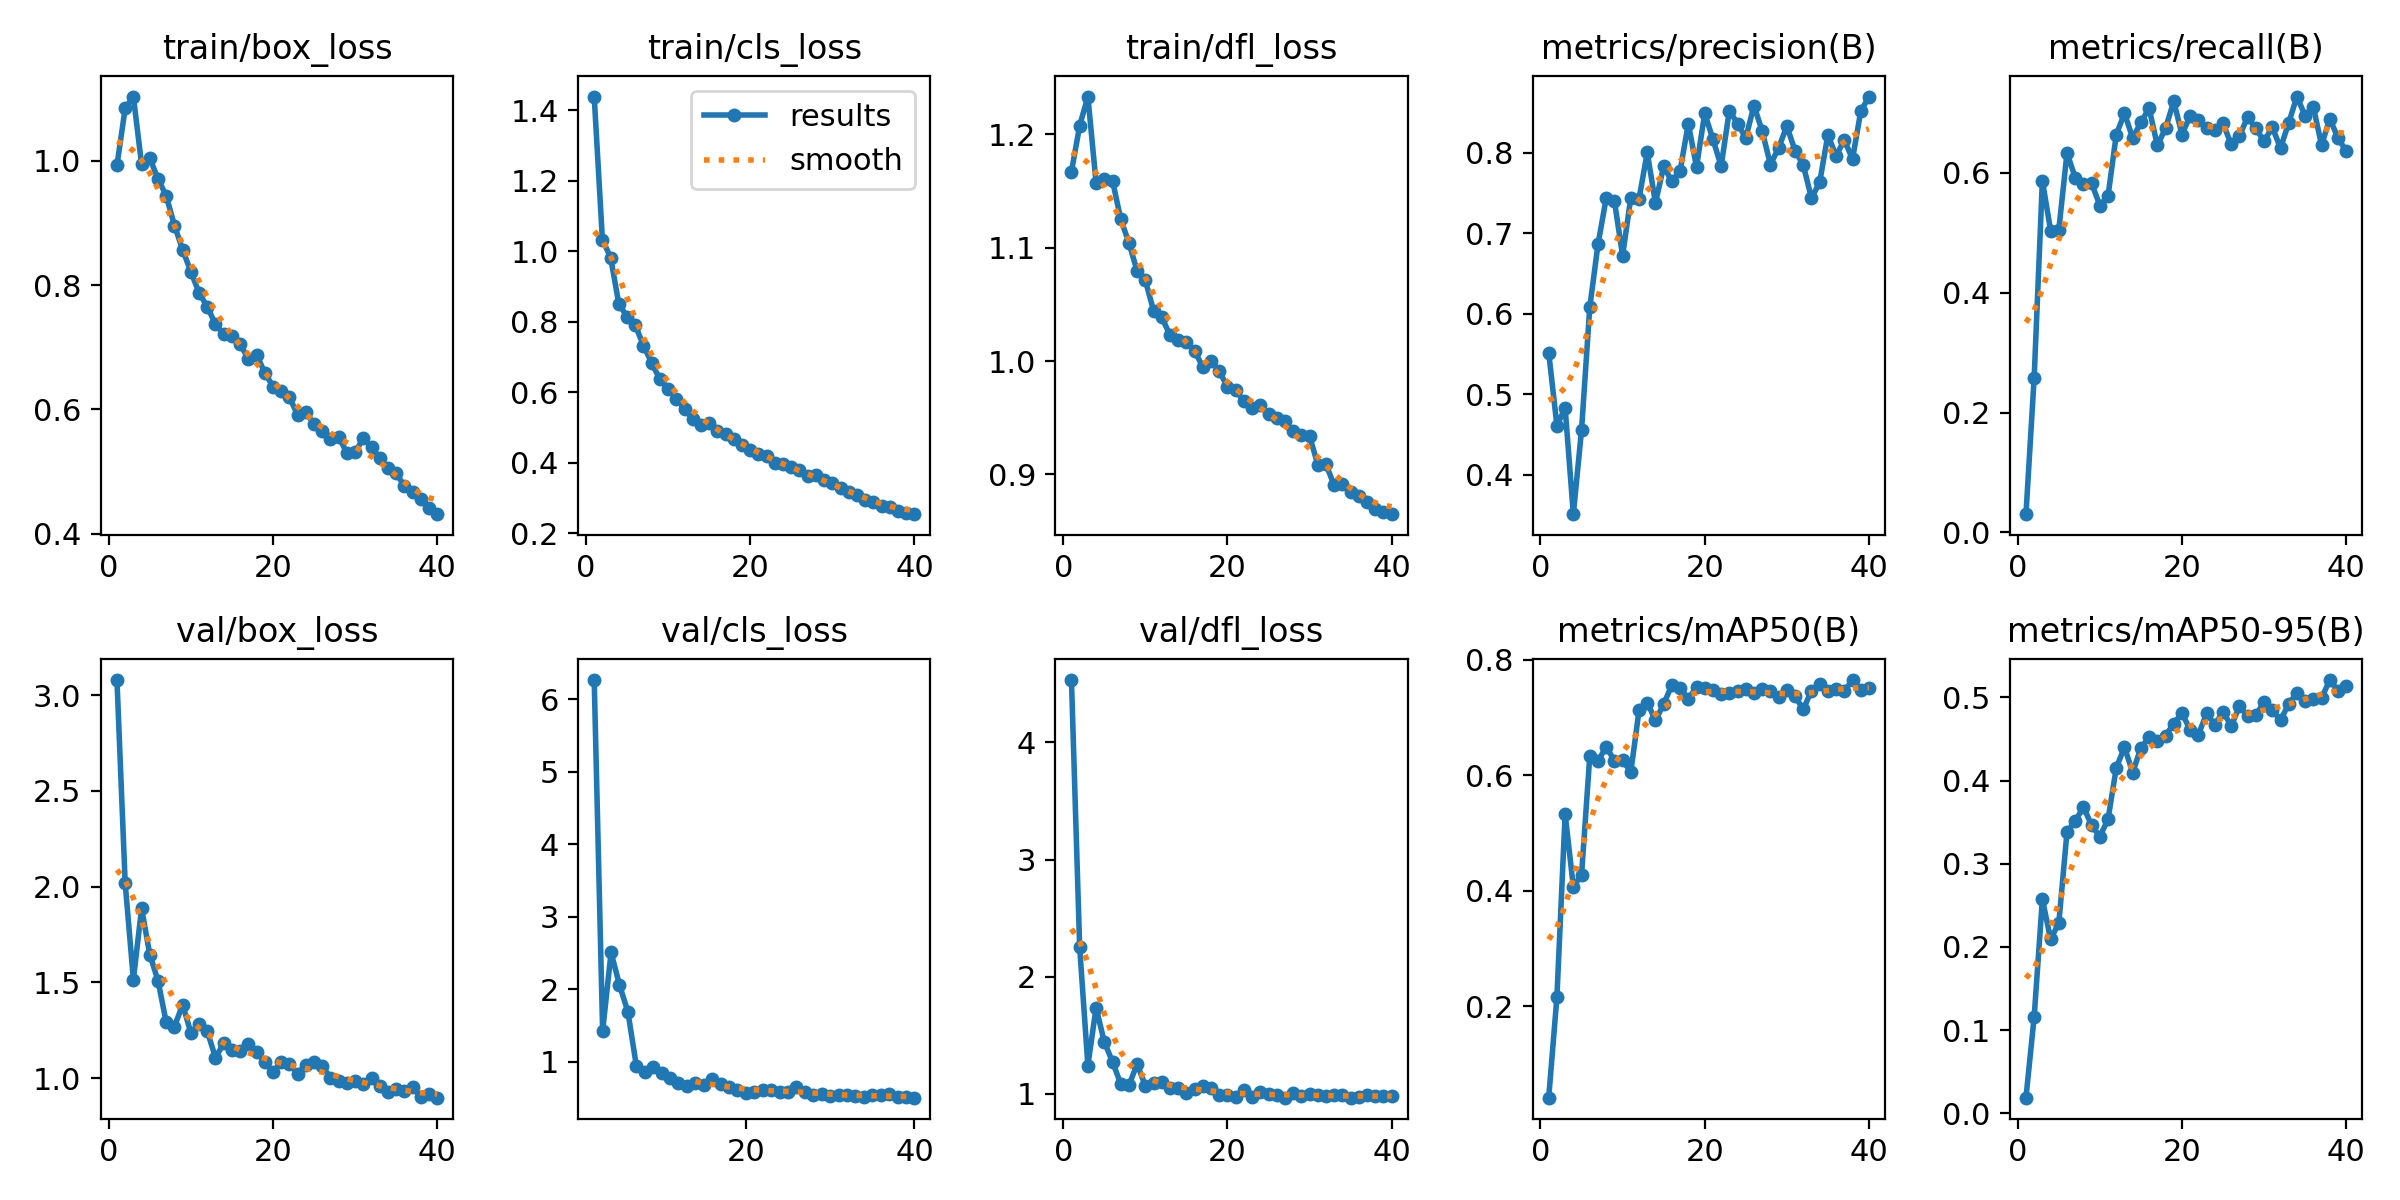

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

# this is the path where ultralytics save results
train_path = "runs/detect/train"

# display
print("Loss curve and metrics during training:")
display(Image(filename=f"{train_path}/results.png"))


In [ ]:
# evaluate the model on the validation set
val_results = model.val()

# print metrics
print("Validation Metrics:")
print(val_results)

# save the optimized model
model.save("best_model_yolo.pt")


Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11x summary (fused): 464 layers, 56,836,264 parameters, 0 gradients, 194.5 GFLOPs


val: Scanning /content/datasets/valid/labels.cache... 270 images, 35 backgrounds, 0 corrupt: 100%|██████████| 270/270 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


                   all        270       1709      0.793      0.691      0.765      0.516
                  bike         25         32      0.644      0.875       0.88      0.592
           green_light         67        181      0.936      0.806      0.896      0.564
              motobike         14         14      0.503        0.5      0.591      0.419
             red_light        165       1194      0.909      0.715      0.866      0.518
         traffic_light         30         34      0.592      0.441      0.487      0.436
          traffic_sign         11         11      0.838      0.545      0.676       0.32
               vehicle        131        223      0.918      0.906       0.96      0.767
          yellow_light          7         20          1      0.739      0.766      0.513
Speed: 0.1ms preprocess, 6.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train2
Validation Metrics:
ultralytics.utils.metrics.DetMetrics object with attributes:


When you think the metrics are good enough for your model, you can implement it in CARLA to see if it is able to detect things !
Before running your own model in CARLA, When testing how to properly use a model in the simulation, we recommend using the basic YOLO model to verify that you can detect things. Then, compare it with your own to see which one performs best !

Your model should be saved by ultralytics in `runs/detect/train_/weights` where you have 2 models saved: best.pt and last.pt. The latter is the last version of the model at the end of training, while the former is the best version of the model during training. We recommend you always use best.pt. Download it and put somewhere you can access easily (like `PythonAPI/Modules/model`) as the rest of the module will be on your local machine and the CARLA server.

## Assignment (Part three - Detecting objects in real-time and avoiding them)

Our fine-tuned Yolo model has been training to recognize objects in CARLA. Now, in order to use it properly in the simulation, there are two important steps left, both in python:

- Doing real-time detection of objects
- Using detection results to send commands to the car.

# Real-time detection

Go to `Simulation_Perception.py` and look for the `CameraManager()` class. It is responsible for creating the sensors for the simulation and managing their outputs.
This is where you are going to add your model. Look for the `_parse_image(weak_self, image)` that format and sends the raw image from the Carla sensor and you will find a commented section where you can add your model. The objectiv is to do object detection on these frames, save the results and then draw bounding boxes on it before sending it as usual.

Once complete, run `Simulation_Perception.py` to see your car detecting objects while moving !
don't forget to add the important arguments for the host and the location of your model :
`Python Simulation_Perception.py --host 192.168.54.10 -m model/best.pt`

If you are not satisfyed with the performance of your model in the simulation you can always come back to Part two and try different technique to improve it ! You can always rely on the base YOLO as well, although it will not allow you to detect traffic light color.

# Reacting to detected objects

Now, you will work on creating your Custom agent that react to anything your model detects.

Go to `Custom_agent.py` and look for the main 2 methods you will be working on: `affected_by_traffic_light()` and `affected_by_vehicle`. Their current version is the default CARLA implementation that relies on ground truth simulation information.

Your mission: change the code inside to rely on you detection model instead. You can still use some of the ground truth information, such as the position where the car has to stop for a specific traffic light.
The only condition is that your car must react to outside objects IF AND ONLY IF your model has detected it!
